In [1]:
from src.data.dataloader import DataLoader
from src.utils.data_utils import update_movie_revenue, preprocess_data_for_model
from src.utils.plots import *
from src.models.ridge import *
from src.models.logistic import *

%load_ext autoreload
%autoreload 2

In [30]:
dataloader = DataLoader()
characters = dataloader.load_characters()
print("Number of characters: ", len(characters))
characters.head()

Number of characters:  503166


,wikipedia_movie_id,wikidata_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_name,actor_age_at_release,ethnicity,wikidata_character_id,wikidata_actor_id
0,975900,Q261700,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,43.0,NaN,NaN,Q1873468
1,975900,Q261700,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,NaN,NaN,Q230527
2,975900,Q261700,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,African Americans,NaN,Q173637
3,975900,Q261700,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,34.0,NaN,NaN,Q169963
4,975900,Q261700,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,24.0,NaN,NaN,Q233347


In [31]:
movies_with_characters = dataloader.load_movies_with_characters()
print("Number of movies with characters: ", len(movies_with_characters))

movies_with_characters.head()

Number of movies with characters:  60911


,wikipedia_movie_id,wikidata_movie_id,Movie name,Movie release date,Movie box office revenue,Movie languages,Movie countries,character_name,actor_gender,actor_height_meters,actor_age_at_release,plot,Movie genres,ethnicity
0,330,Q2823770,Actrius,1996,NaN,"Catalan language, Spanish Language",Spain,,"F, F, F, F",,"55.0, 30.0, 52.0, 61.0",In order to prepare the role of an important o...,Comedy,Southern European Ethnicities
1,3217,Q471992,Army of Darkness,1992,21502796.0,English Language,United States of America,"S-Mart Clerk, Fake shemp, Ash Williams, Evil A...","M, M, M, M, M, F, F, F, M, M, M, M, M","1.87, 1.85, 1.85, 1.87, 1.68, 1.73, 1.75, 1.87...","27.0, 36.0, 34.0, 34.0, 27.0, 28.0, 27.0, 35.0...","After being pulled through a time portal, Ash ...","Action, Adventure, Comedy, Drama, Fantasy and ...","Western European Ethnicities, American Ethnici..."
2,3333,Q220394,The Birth of a Nation,1915,50000000.0,"Silent film, English Language",United States of America,,"F, F, M, M, F, F, M, M, M, M, F, F, M, M, M, M...","1.66, 1.66, 1.6, 1.6, 1.8, 1.8, 1.6, 1.6, 1.66...","22.0, 22.0, 37.0, 37.0, 21.0, 21.0, 47.0, 47.0...",The film follows two juxtaposed families: the...,"Drama, War and Political, Experimental and Ind...",
3,3746,Q184843,Blade Runner,1982,33139618.0,"Japanese Language, Cantonese, English Language...","United States of America, Hong Kong","J.F. Sebastian, Rick Deckard, Roy Batty, Racha...","M, M, M, F, F, F, M, M, M, M, M, M, M, M","1.727, 1.85, 1.85, 1.753, 1.78, 1.753, 1.905, ...","34.0, 40.0, 38.0, 23.0, 22.0, 37.0, 37.0, 38.0...","{{Hatnote}} In Los Angeles, November 2019, ret...","Fantasy and Science Fiction, Crime and Mystery","Western European Ethnicities, Latin American E..."
4,3837,Q957323,Blazing Saddles,1974,119500000.0,"Yiddish Language, English Language",United States of America,"Gabby Johnson, Taggart, Rev. Johnson, Mongo, B...","M, M, M, M, M, M, M, M, M, F, M, M, M, M, F, M...","1.91, 1.7, 1.88, 1.78, 1.65, 1.6, 1.7, 1.91, 1...","38.0, 55.0, 64.0, 58.0, 39.0, 41.0, 44.0, 36.0...","In the American Old West of 1874, construction...",Comedy,"African Ethnicities, Southern European Ethnici..."


In [6]:
# Scarp wikidata to get missing movie revenues
movies_with_characters = update_movie_revenue(movies_with_characters)  # 20 min runtime

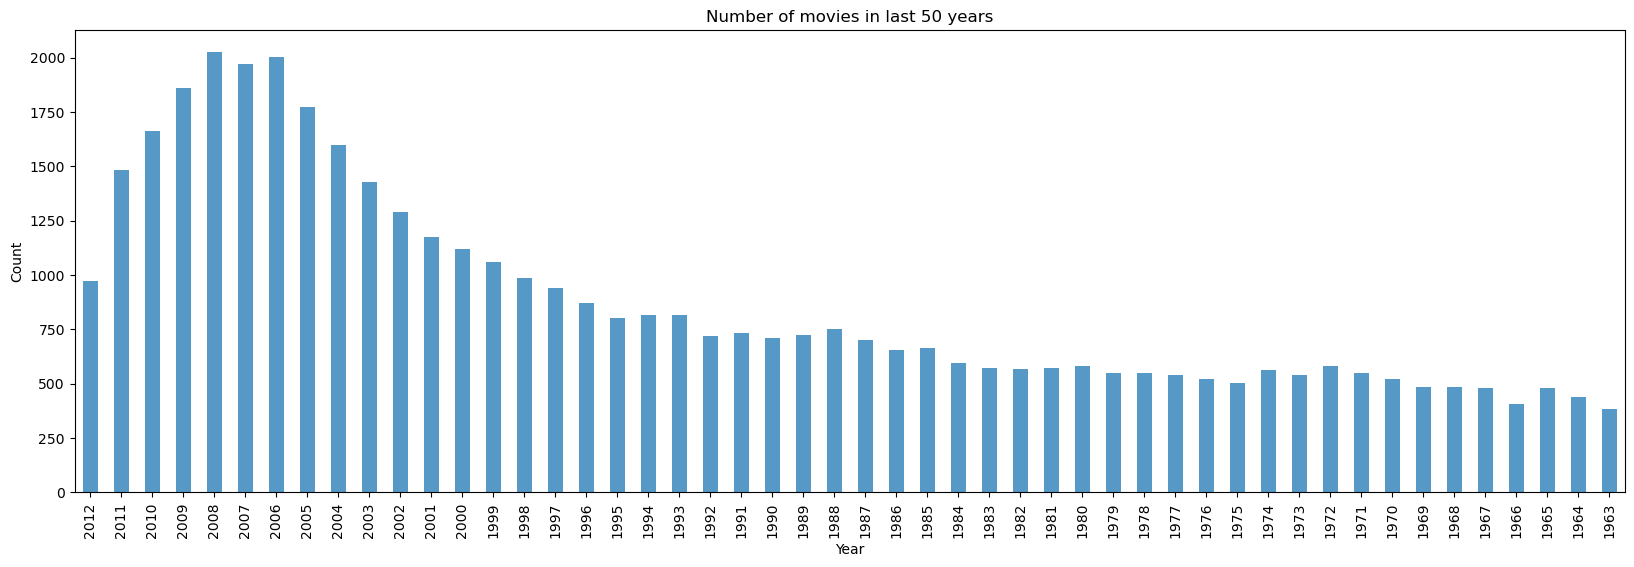

In [4]:
# Plot the number of movies by year
plot_movies_by_year(movies_with_characters)

**Observations :** Observing distribution of movie release date in our dataset, we can notice as expected that the number of movies released per year grows over time, with a larger increase by the end of the 90's, then a significant decrease after 2008 (although this change in tendency is most likely related to less movies being included in the dataset rather than any kind of drastic change in the movie industry, it can be fun however to wonder if this observation could actually be related to the 2008 economic crisis which might have affected financing in the movie industry).

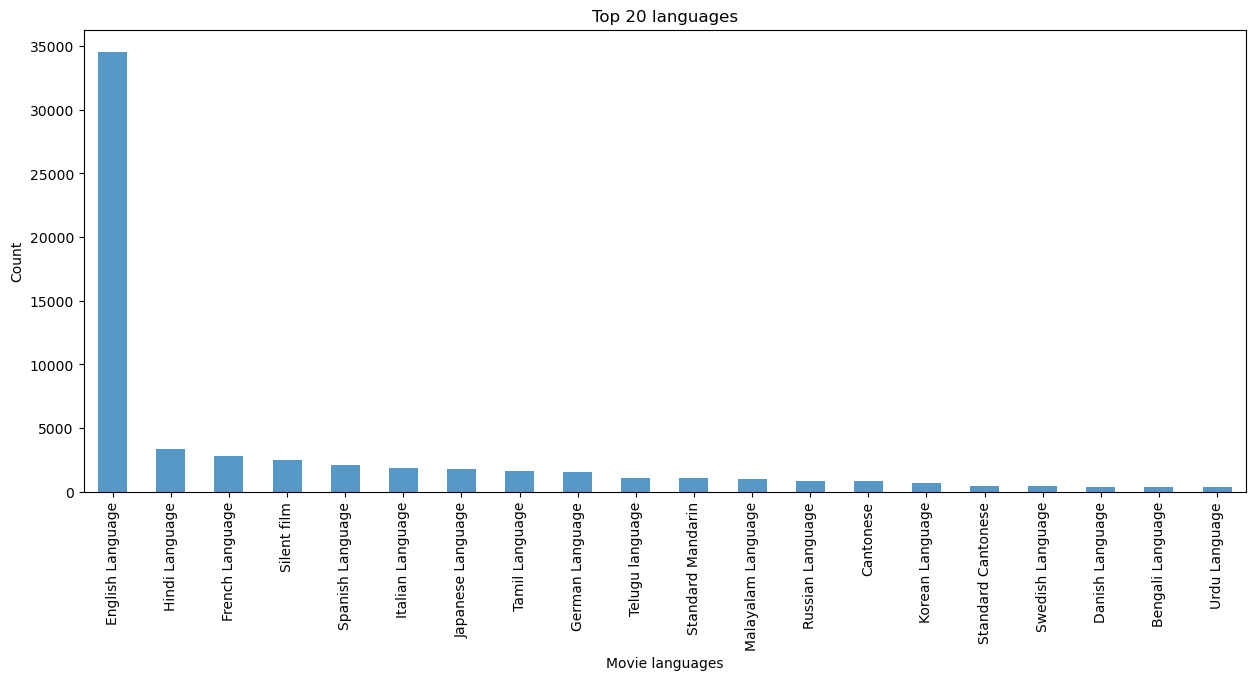

In [5]:
# Plot the top languages
plot_top_languages(movies_with_characters)

**Observations :** The distribution of movie languages over the years allowed us to detect a major data imbalance in our dataset, with most movies being released in english, as well as an important number of movie release languages with a very small number of movies associated. Following this observation, we decided to only focus on movies released in english to avoid such skewed distribution to affect our model reliability.

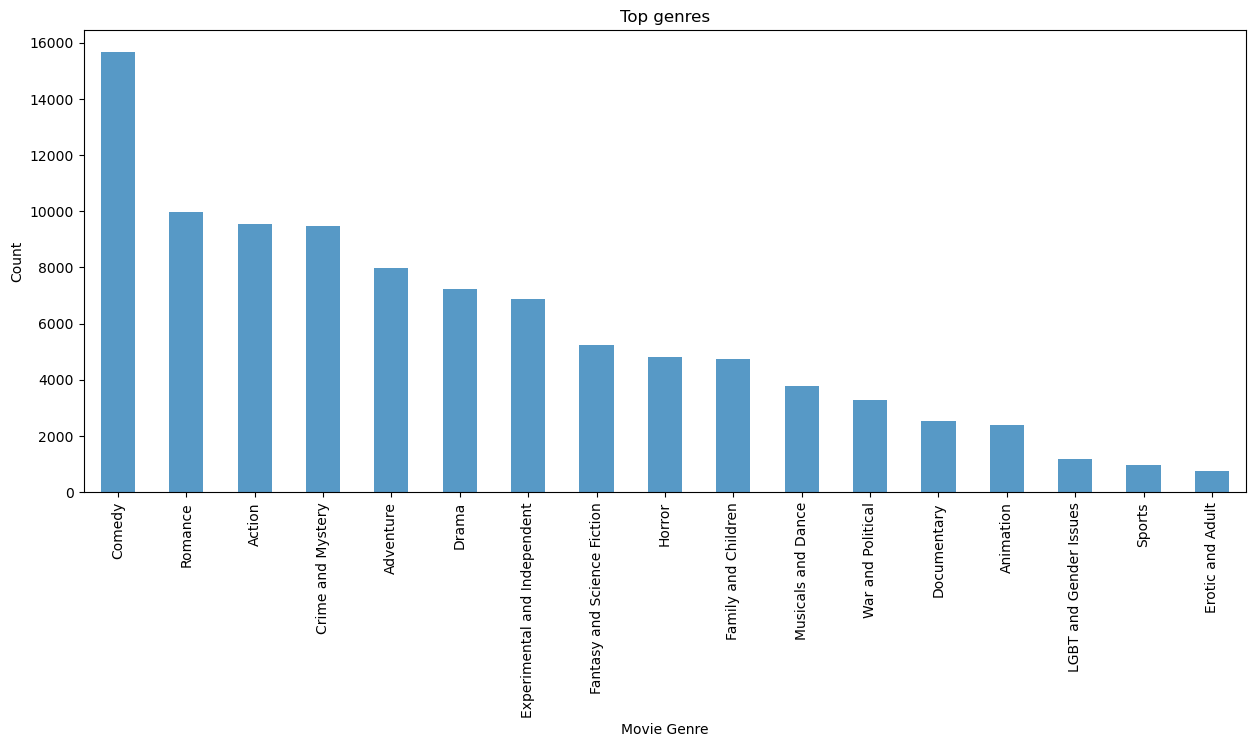

In [6]:
# Plot the top movie genres
plot_top_genres(movies_with_characters)

**Observations :** Observing the distribution of movie genres is an important step for detecting data imbalance in our datasets. In particular, we could notice an important number of represented movie genres in our dataset, and we only decided to show the distribution of the 20 most important ones. We could observe that the distribution of movie genres was mainly dominated by the Drama genre, which we should be aware of when training our model.

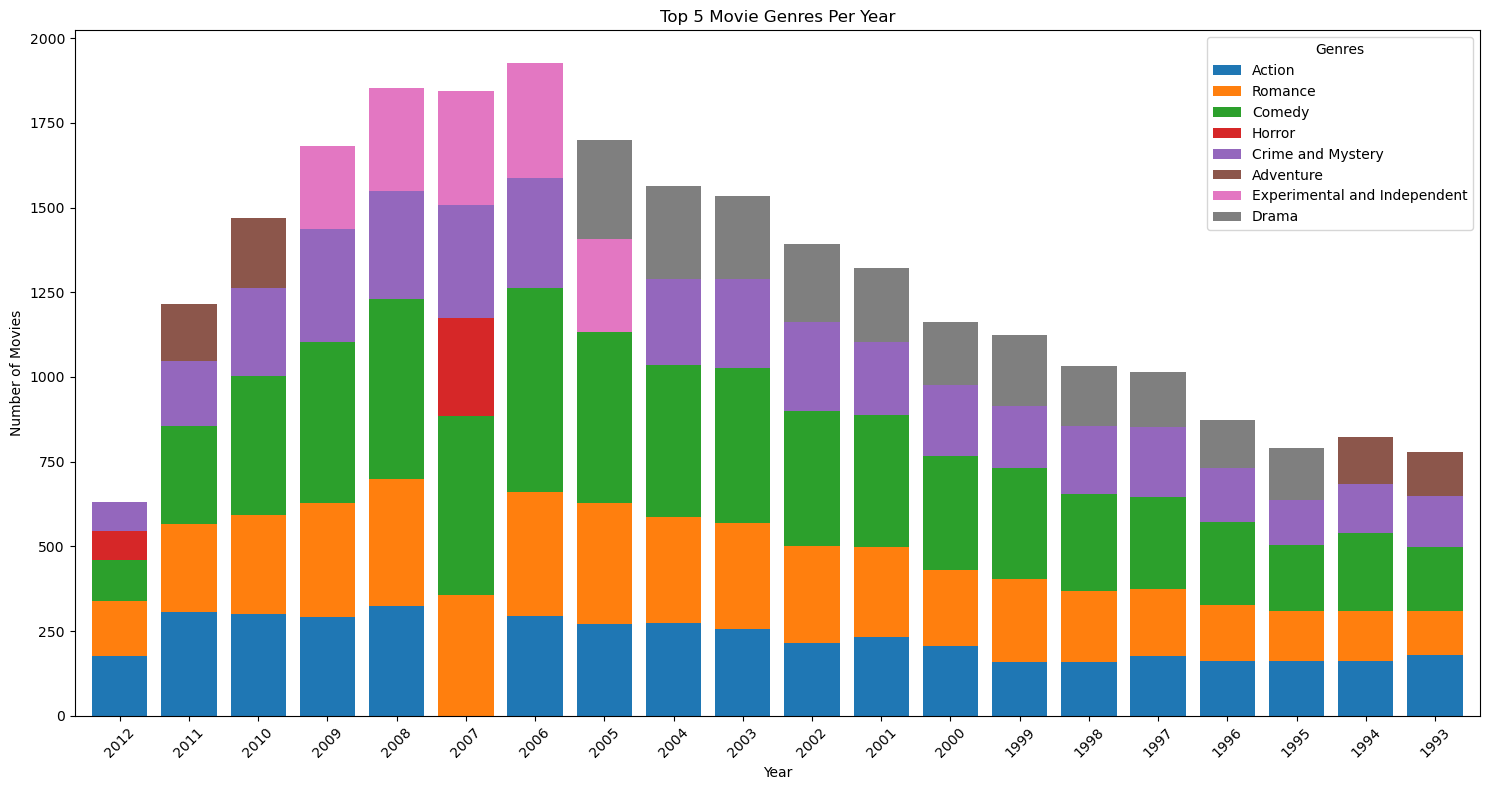

In [7]:
# Plot the top 3 genres by year for the last years
plot_top_genres_by_year(movies_with_characters)

**Observations :** As one could easily expect, Drama movies seem to represent a large fraction of released movies in our data set. We could however notice some trends in the most represented genres in cinema, with comedy movies taking more importance over the years, as well as resurgence of thriller and action movies after 2006 and 2009 respectively.

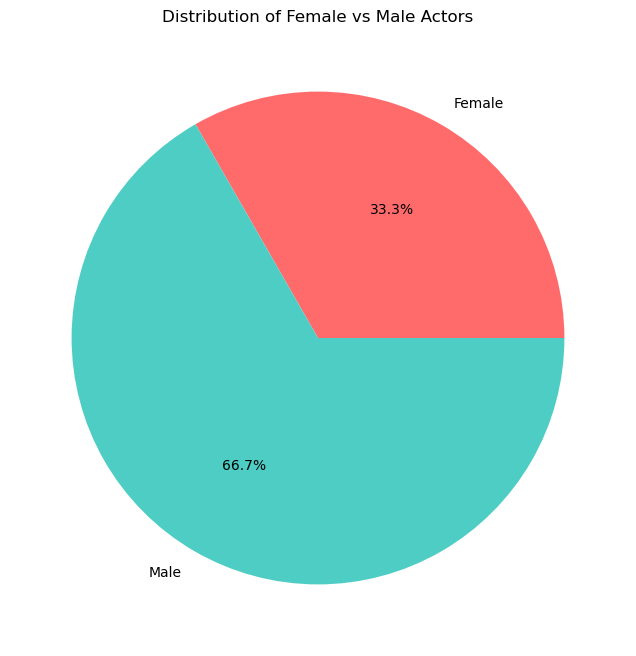

In [8]:
# Plot the gender distribution
plot_gender_distribution_pie(movies_with_characters)

**Observations :** We can see that there is a little less than twice the number of male actors than that of female actors. That is why it will be interesting to see the evolution of this representation over time.

<Figure size 1200x600 with 0 Axes>

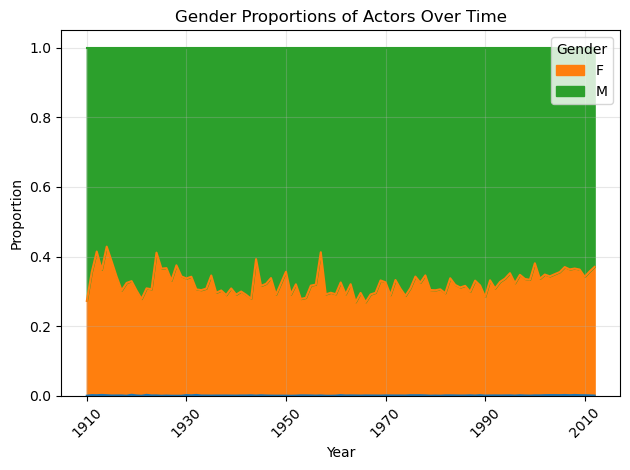

In [9]:
# Plot gender proportions of actors over time
plot_gender_proportions(movies_with_characters)

**Observations :** The distribution of actors' gender over time in our dataset reveals interesting patterns that somewhat contradicts our prior beliefs. As expected, the distribution of actors' gender in our movie dataset is mainly dominated by male actors, however the increase in proportion of actors of whichever gender is non-trivial (ie. it is hard to assess so far if the proportion of female actors has incresed over time in our movie dataset).

<Figure size 1200x600 with 0 Axes>

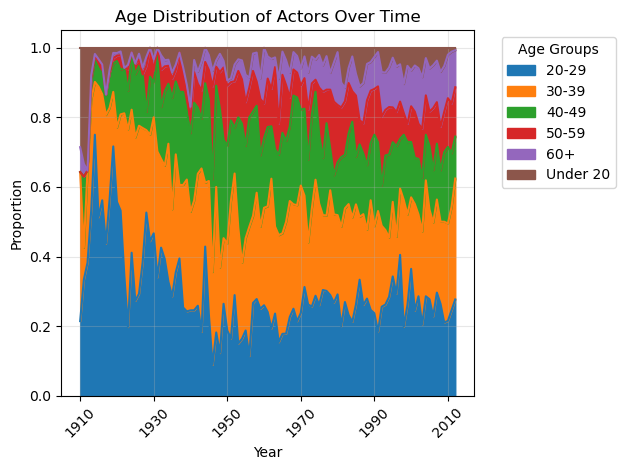

In [10]:
# Plot age proportions of actors over time
plot_age_proportions(movies_with_characters)

**Observations :** The distribution of actors ages over time also reveals some interesting trends. In particular, distribution of segmented age groups tend to balance overall in the 2000s, which could potentially reflect greater attention from the industry regarding various age groups and their representation in movies.

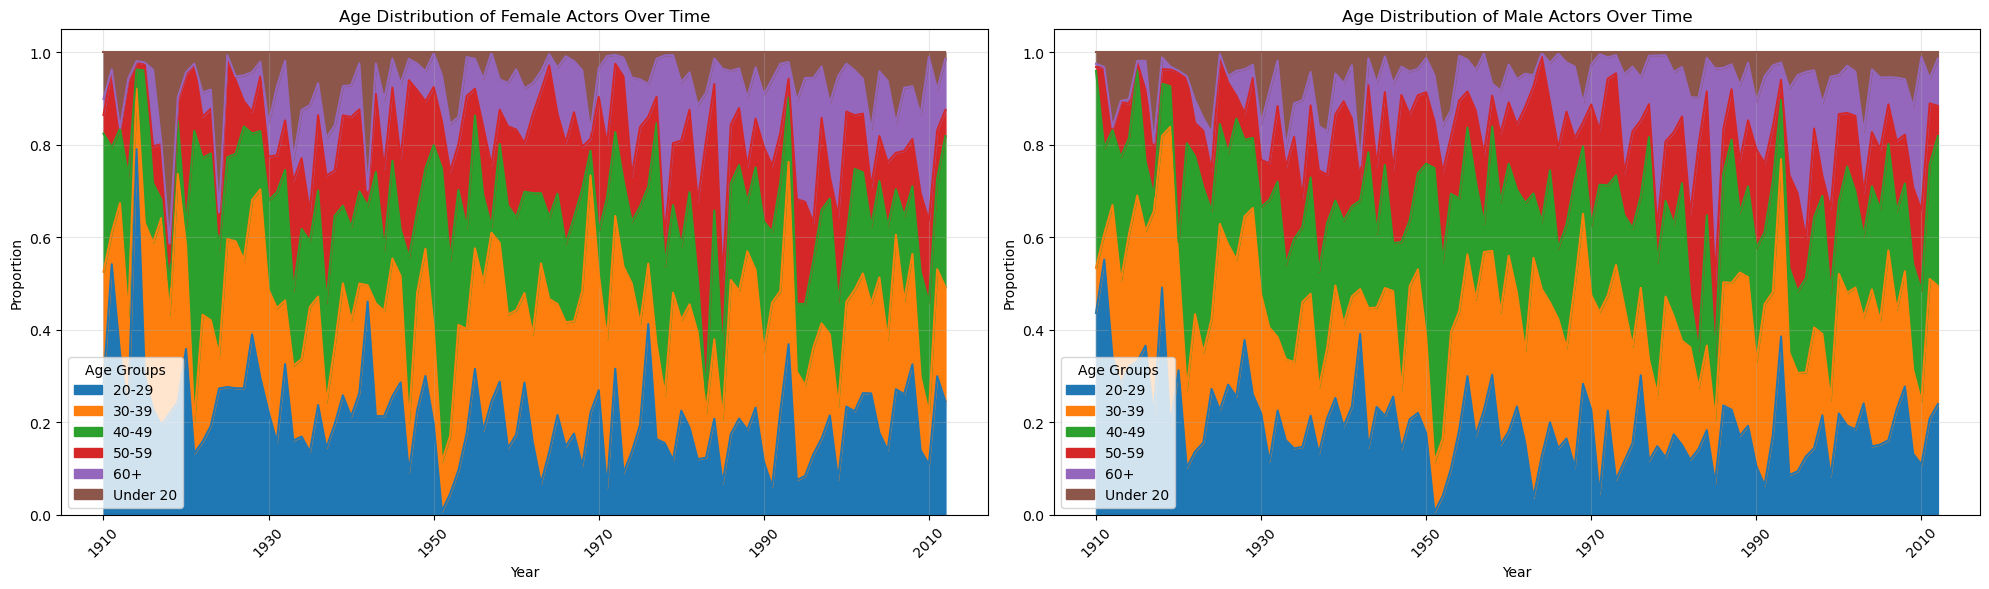

In [10]:
# Plot age proportions of actors over time by gender
plot_age_proportions_by_gender(movies_with_characters)

**Observations :** Additionnally, the distribution of actors' age groups for each gender over time highlights interesting patterns. In particular, one could easily notice that the proportion of young female actresses whose age is between 20 and 29 years is roughly twice larger than for male actors of the same age group since the 1950's, while the proportion of female actresses between 50-59 years old, 40-49 years old and 60+ years old remains lower than for men actors in the same age groups. Such distribution could be revealing of trends regarding the character roles that tend to be played by each gender and their representation in movies.

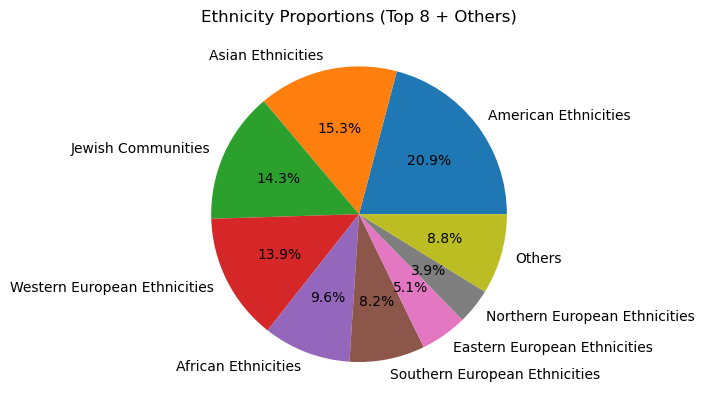

In [11]:
# Plot the actor's ethnicity proportions
plot_ethnicity_proportions(movies_with_characters)

**Observations :** We can see that Indians are the most represented ethnicity in the dataset, likely due to the large number of movies from the Bollywood industry. They are followed by various American ethnicities, probably because of the high volume of movies from Hollywood.

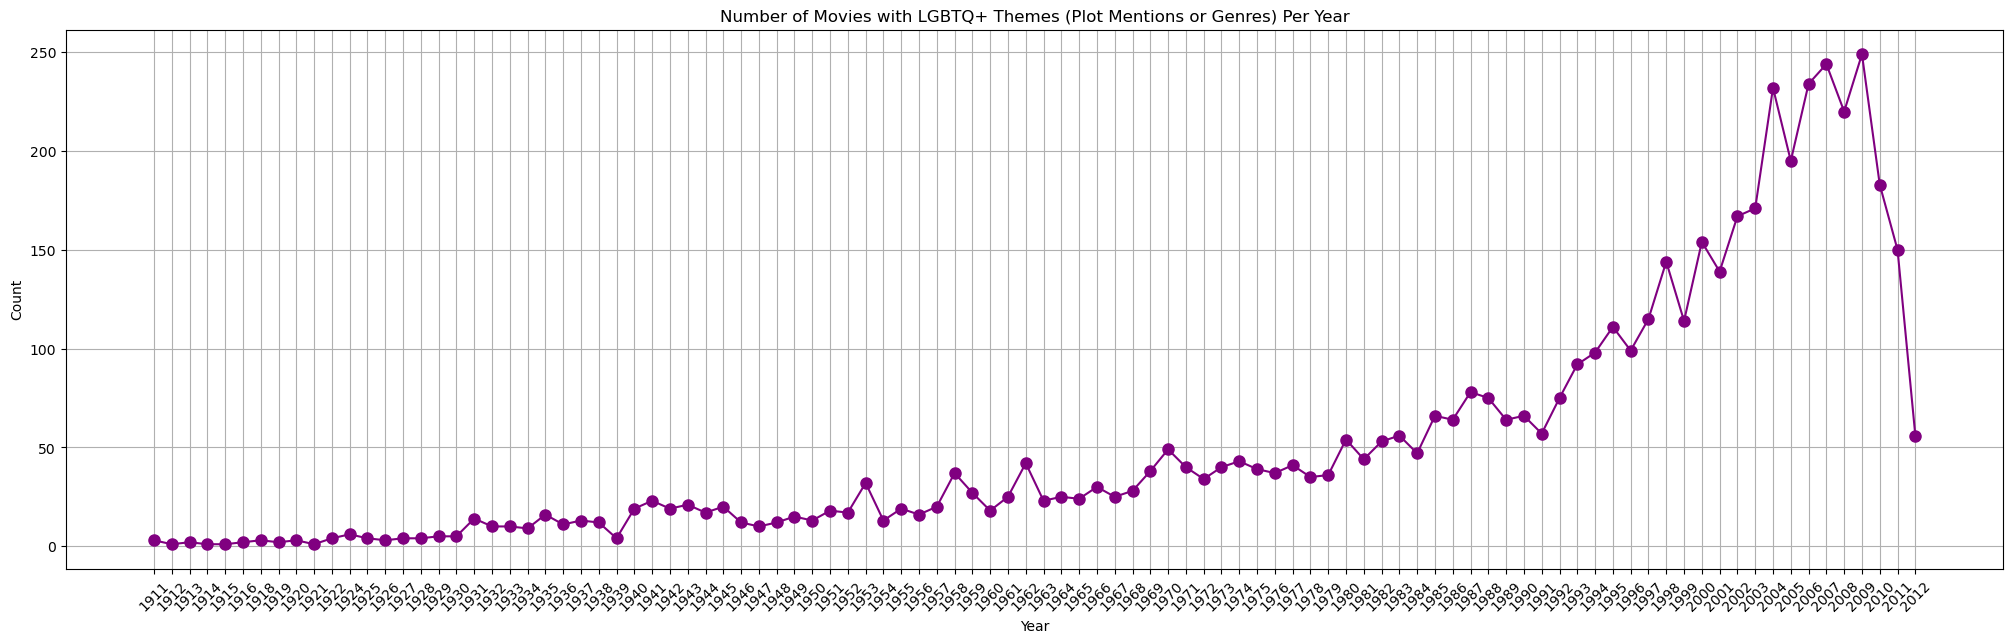

In [12]:
# Plot the number of lgbtq related words in movie plot summaries over time
plot_lgbtq_movies_per_year(movies_with_characters)

**Observations :** We can see that the number of movies that have an LGBTQ+ theme (either in the plot or in the genres) is globally increasing over time, but the number of movies released each year is also increasing, so analysing the mean percentage of movies with LGBTQ+ themes per year is more relevant.

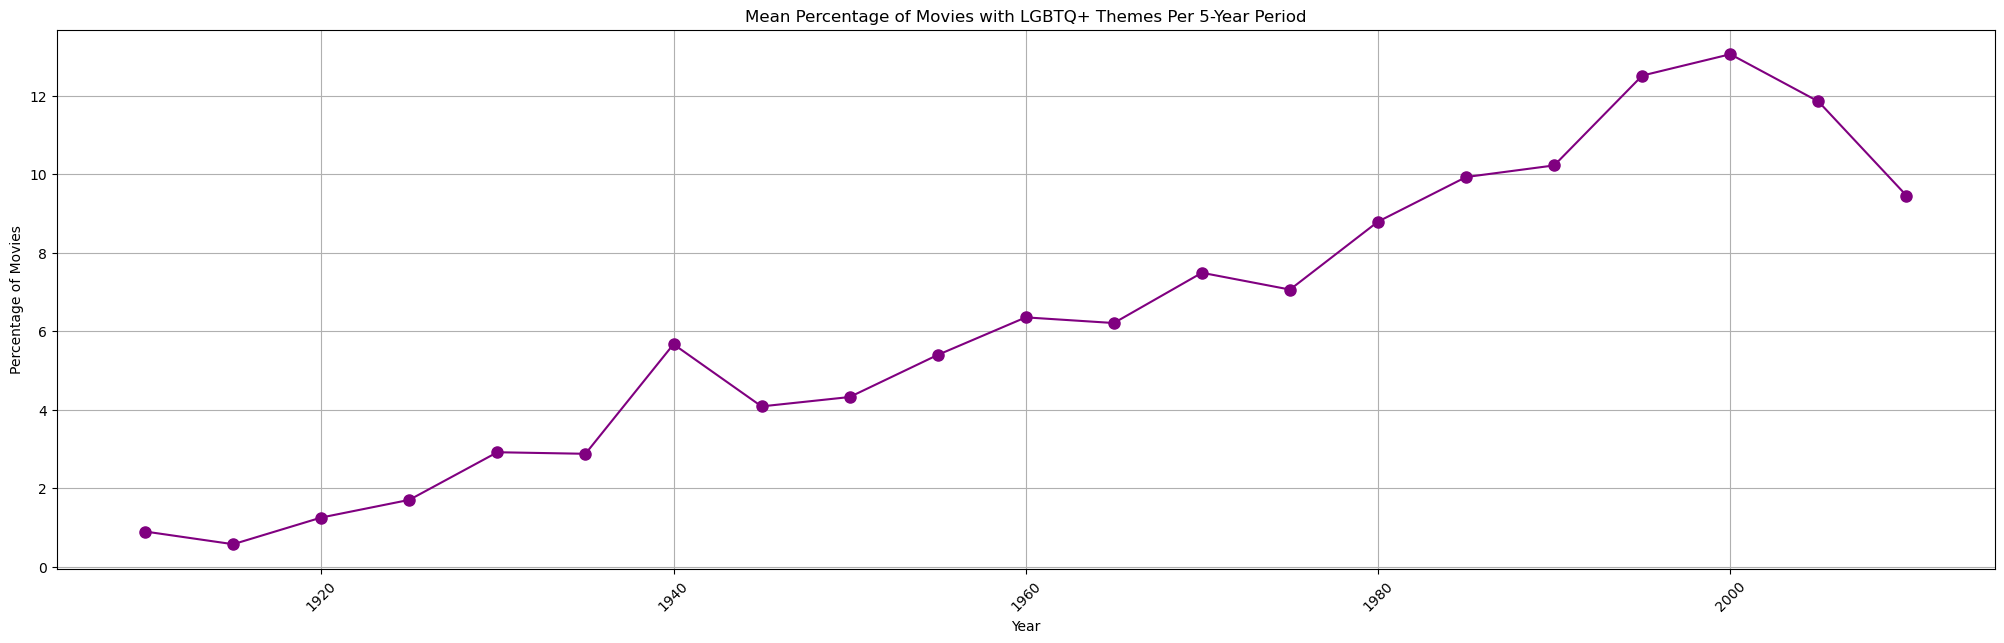

In [13]:
# Plot the percentage of movies with LGBTQ+ themes per 5-year period
plot_lgbtq_movies_percentage_per_period(movies_with_characters)

**Observations :** The mean percentage of movies with an LGBTQ+ theme is also increasing over time, confirming the tendency of the movie industry to become more inclusive over time.


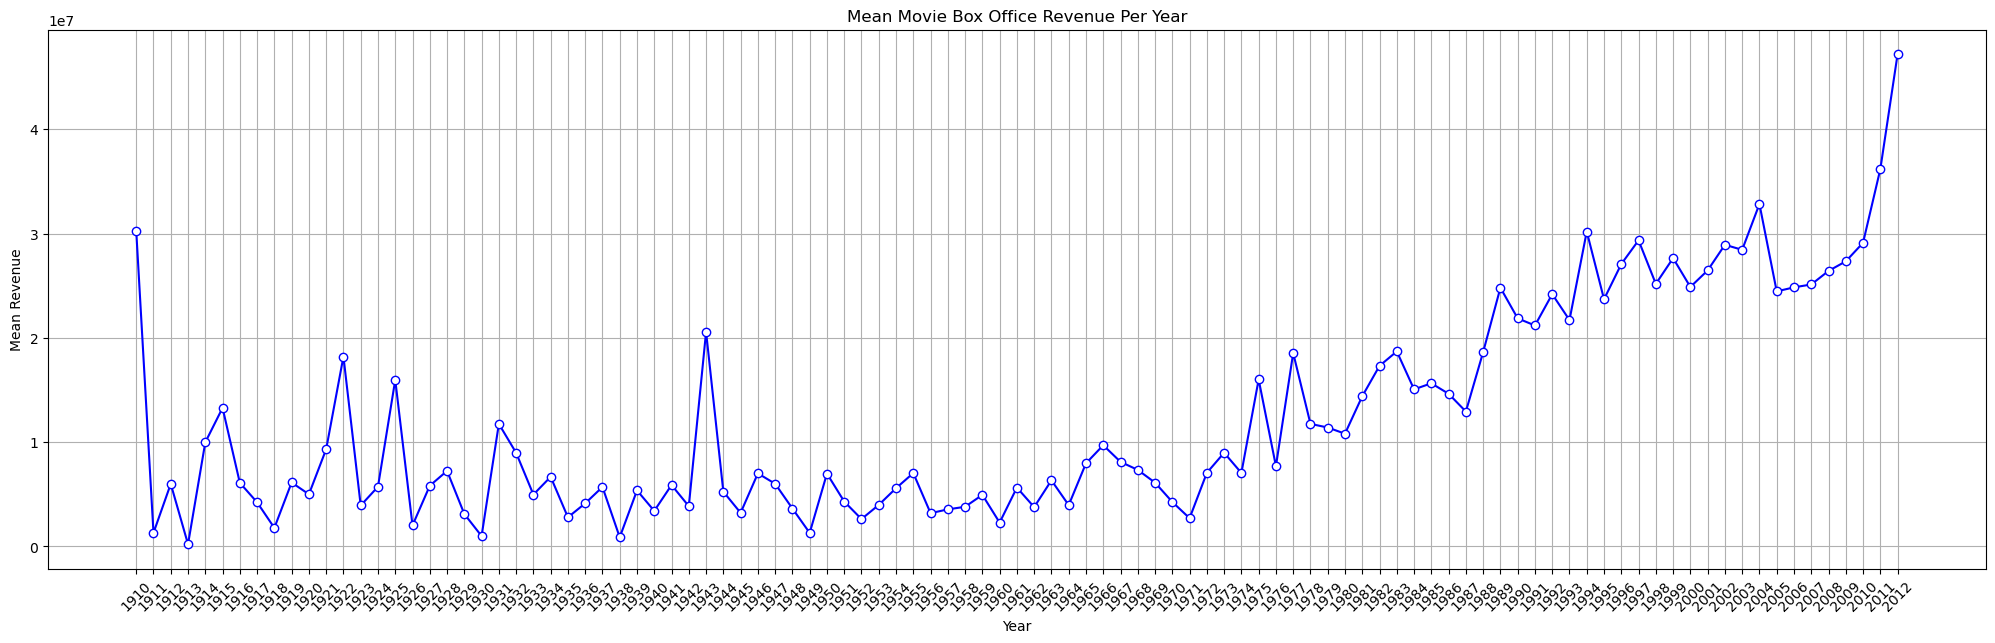

In [14]:
# Plot the mean revenue per year
plot_mean_revenue_per_year(movies_with_characters)

**Observations:** The mean box office revenue is globally increasing over time. However, we can see some spikes at different points in time, which could be due to certain years when the movie industry was more successful than others. This graph is representative, as the distribution of the count of movies per year evolves smoothly over time. However, we should consider the time value of money when interpreting this graph, and standardizing the data for each year would be good practice.

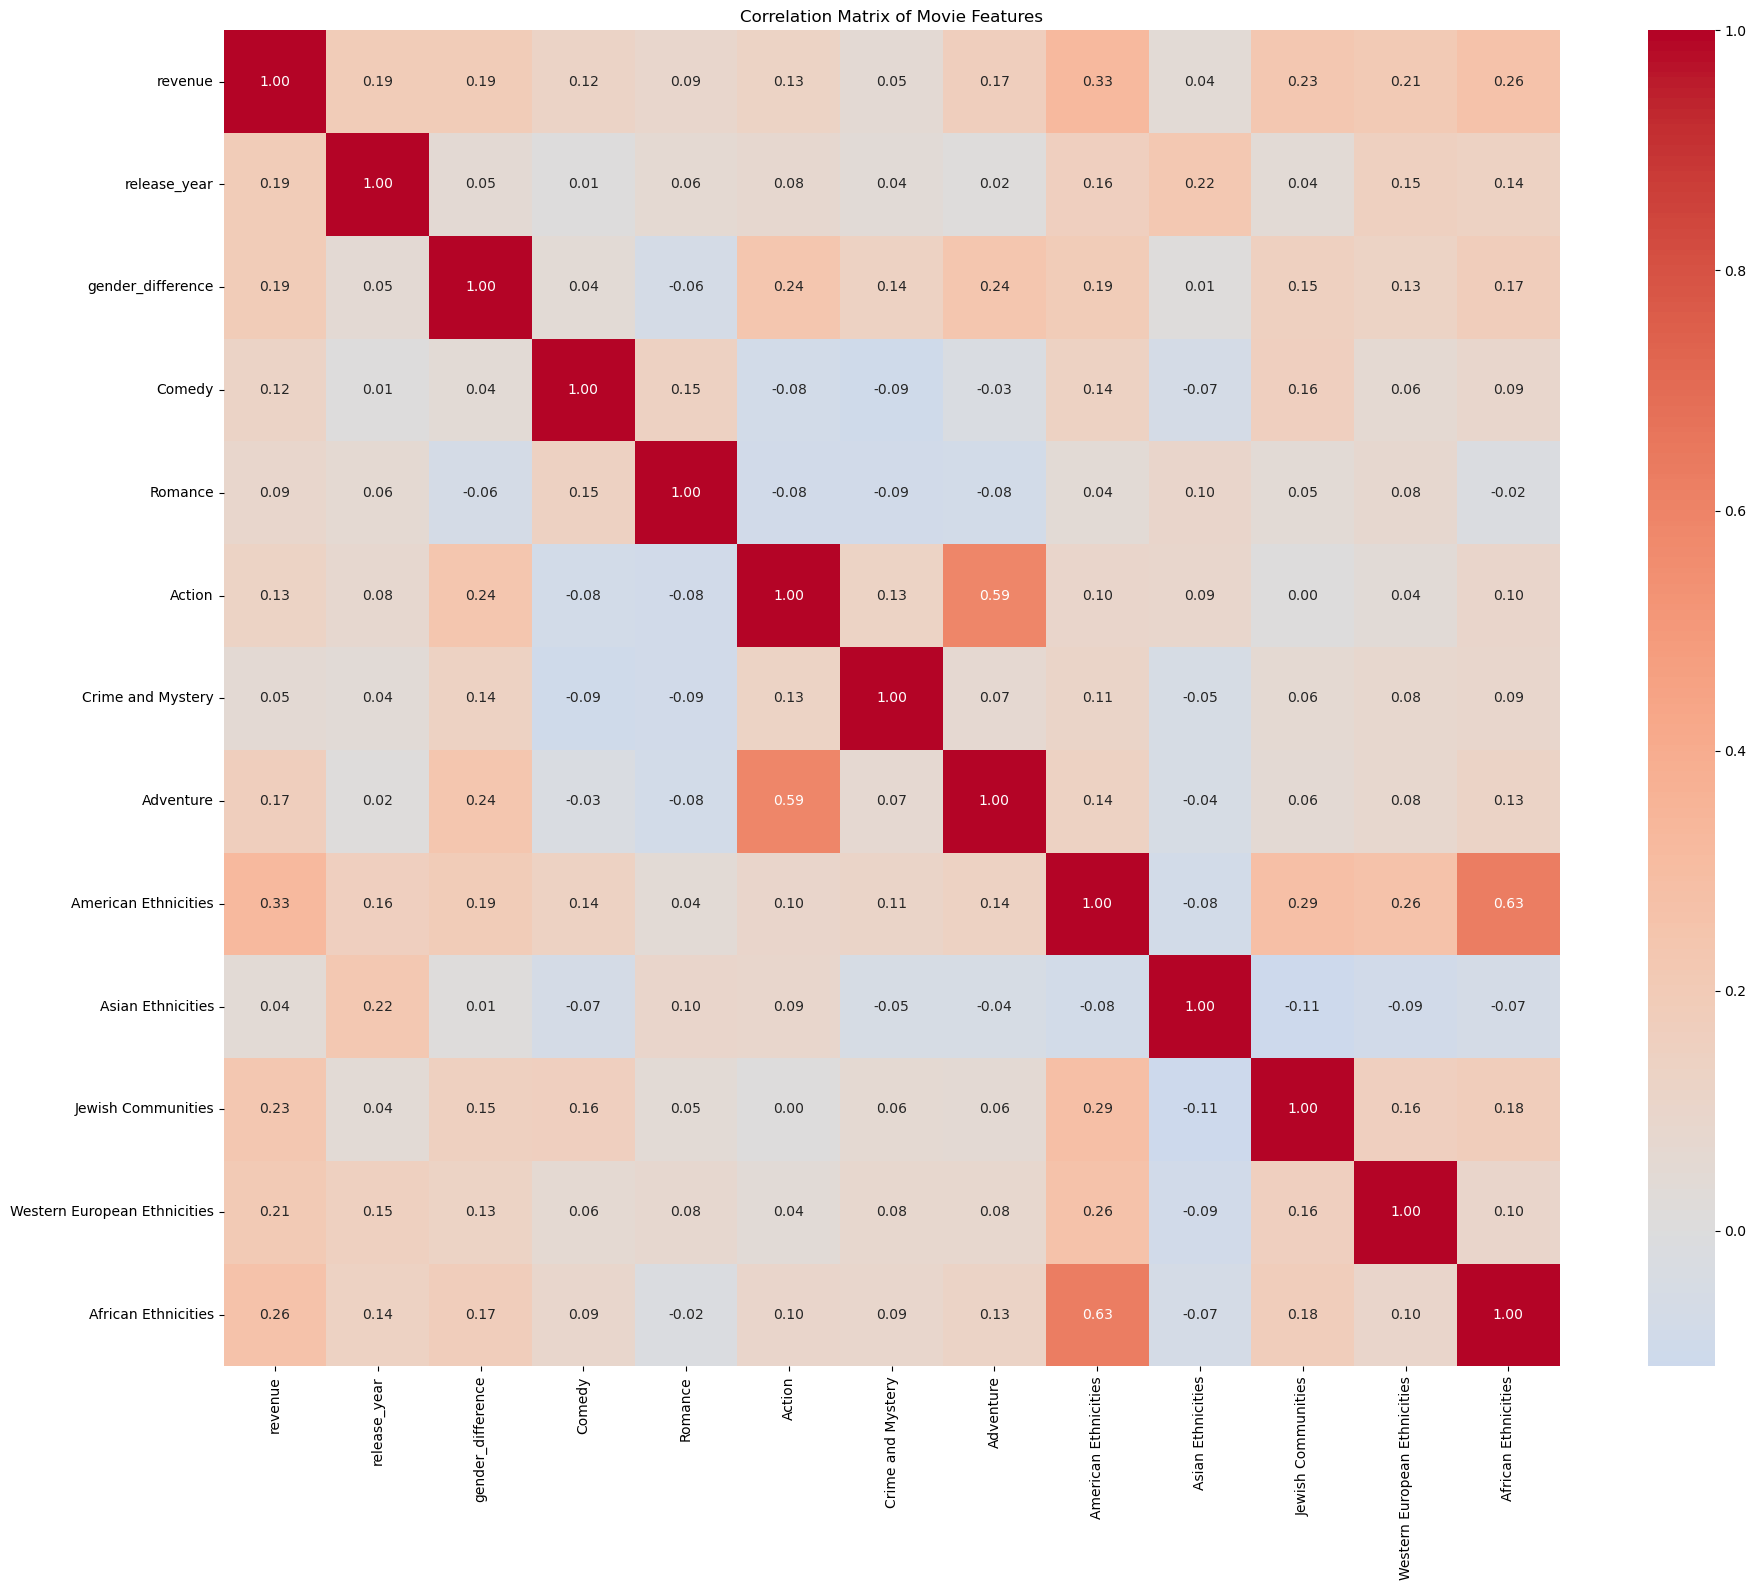


Top 5 positive correlations with revenue:
revenue                         1.000000
American Ethnicities            0.329583
African Ethnicities             0.257586
Jewish Communities              0.230252
Western European Ethnicities    0.210663
Name: revenue, dtype: float64

Top 5 negative correlations with revenue:
Action               0.134034
Comedy               0.119976
Romance              0.092336
Crime and Mystery    0.052554
Asian Ethnicities    0.043920
Name: revenue, dtype: float64


In [15]:
# Plot the correlation matrix of the features
plot_correlation_matrix(movies_with_characters)

**Observations :** Visualizing the correlation matrix allowed us to determine the most relevant features for our model. We printed the most correlated features with movie revenue, yet we keep in mind that strong correlation does not necessarily mean causation, and we therefore need to do more advancedstatistical analysis in our models.

In [16]:
df = preprocess_data_for_model(movies_with_characters)
df.head()

,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_min,actor_age_at_release_max,actor_height_meters_min,actor_height_meters_max,,...,Indigenous Peoples,Jewish Communities,Latin American Ethnicities,Middle Eastern and Arab Ethnicities,Northern European Ethnicities,Oceanian Ethnicities,Southern European Ethnicities,Western European Ethnicities,period,ethnic_score
30901,1910,10424470.0,9,18,0.333333,18.0,23.0,-5.0,17.0,0,...,0,0,0,0,0,0,0,1,1910-1914,1
35918,1914,263591415.0,121,0,1.000000,22.0,22.0,-6.0,-6.0,0,...,0,0,0,0,0,0,0,0,1910-1914,0
2,1915,50000000.0,24,32,0.428571,12.0,56.0,0.0,20.0,0,...,0,0,0,0,0,0,0,0,1915-1919,0
34688,1916,38901218.0,8,16,0.333333,31.0,58.0,8.0,8.0,1,...,0,1,0,0,0,0,0,0,1915-1919,1
28934,1916,1143856.0,0,1,0.000000,29.0,29.0,18.0,18.0,0,...,0,0,0,0,0,0,0,0,1915-1919,0


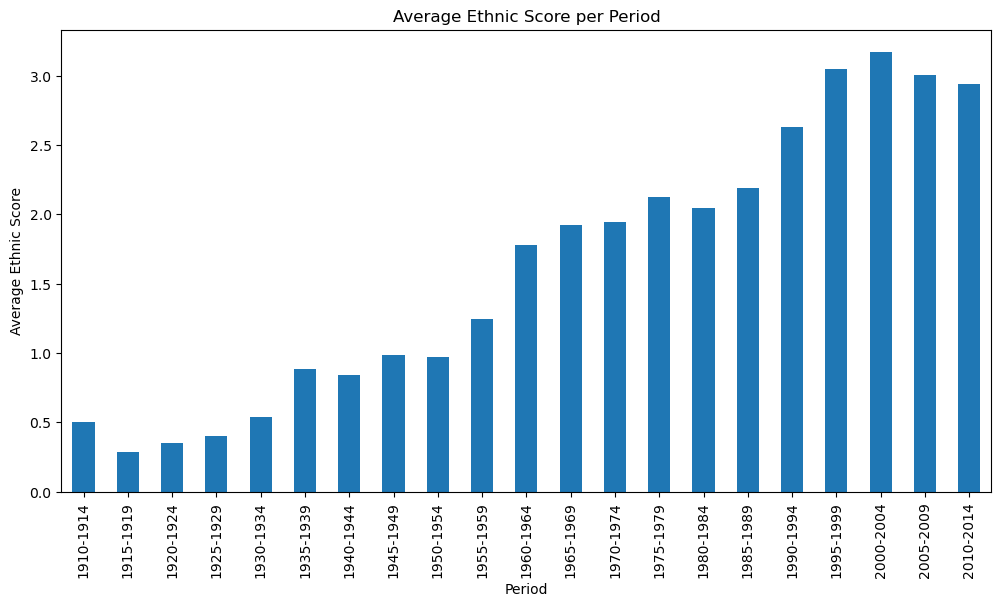

In [17]:
plot_avg_ethnic_score_evolution(df)

**Observations :** We can see that the average ethnic score is increasing over time, revealing that the movie industry indeed tend to be more diversified nowadays.

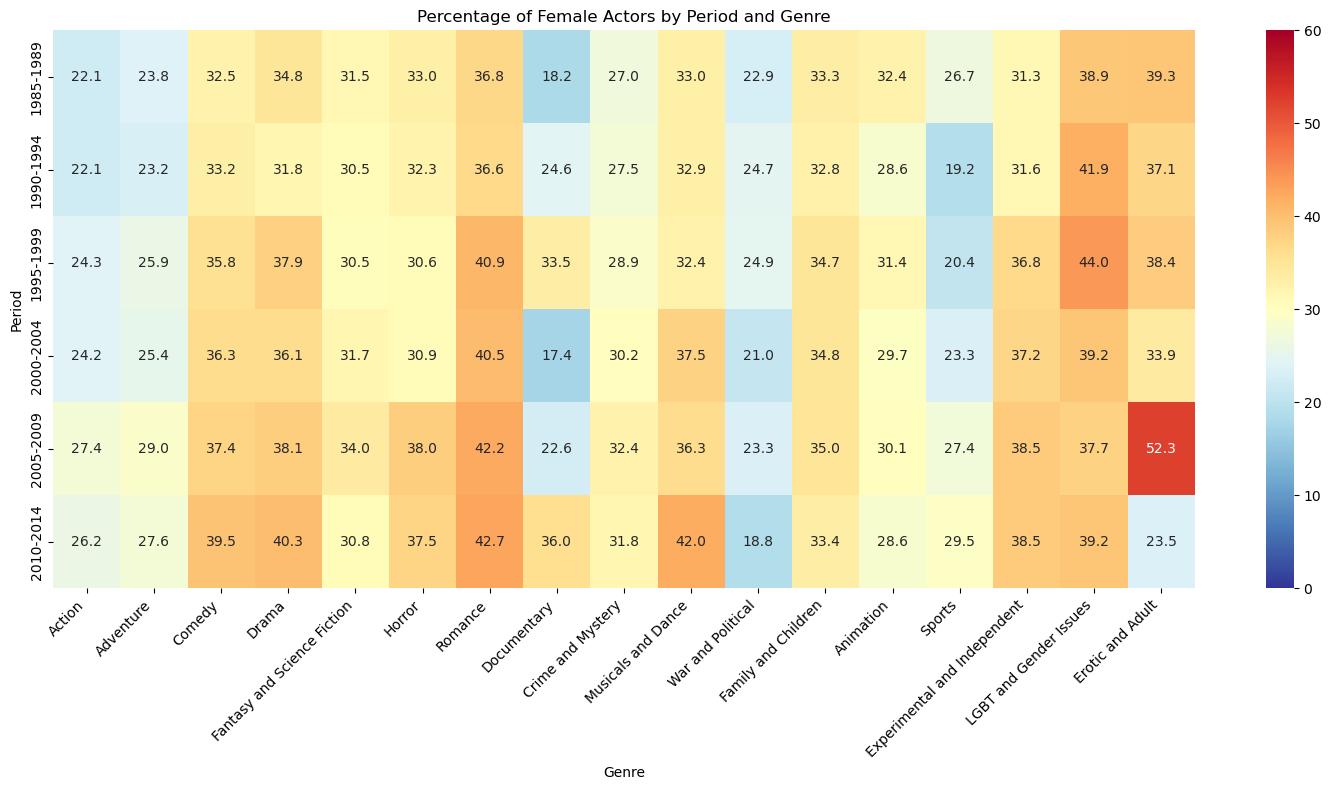

In [18]:
plot_female_ratio_heatmap(df)

**Observations:** We can see that Erotic and Adult films maintain the highest female representation, peaking at 52.3% in 2005–2009, emphasizing their focus on women. Drama also shows consistent progress, surpassing 40% representation in the 2010–2014 period. Action and Adventure genres remain male-dominated, with female representation fluctuating between 22–29%. Comedy and Animation show gradual increases, nearing 40% by the latest period, while Documentary and Crime and Mystery remain steady but lower. Overall, female representation varies significantly across genres, reflecting slow but steady progress toward inclusivity in some categories while traditional gender norms persist in others.

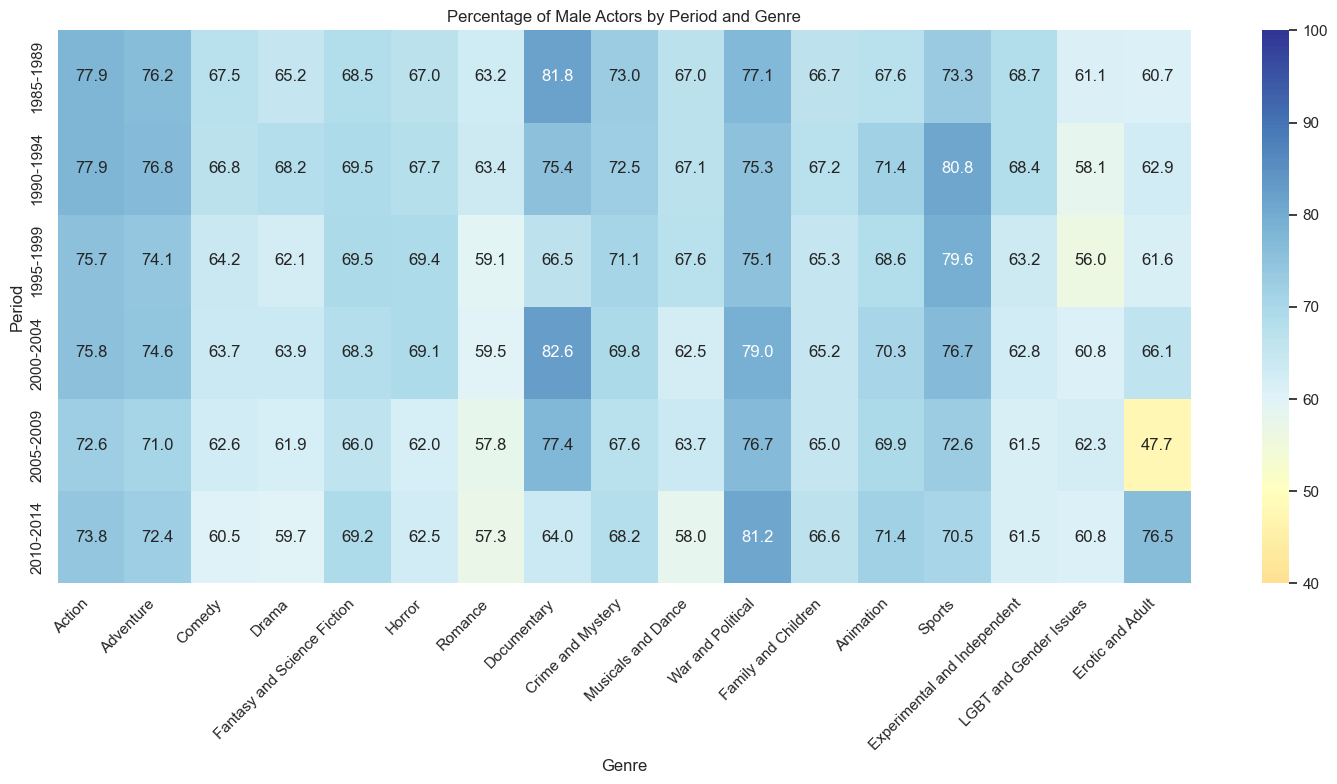

In [27]:
plot_male_ratio_heatmap(df)

**Observations:** Men continue to dominate most movie genres, with representation consistently above 60–80%. Action, Adventure, and War genres remain particularly male-heavy, reinforcing traditional gender roles. However, genres like Comedy, Crime, and Sci-Fi show a gradual decline in male dominance, signaling progress toward gender balance. Notably, Romance and Erotic films exhibit a more even split, reflecting their focus on relationships and intimacy. While some genres are slowly balancing gender representation, the persistent male dominance highlights the deep-rooted norms that have historically shaped cinema.

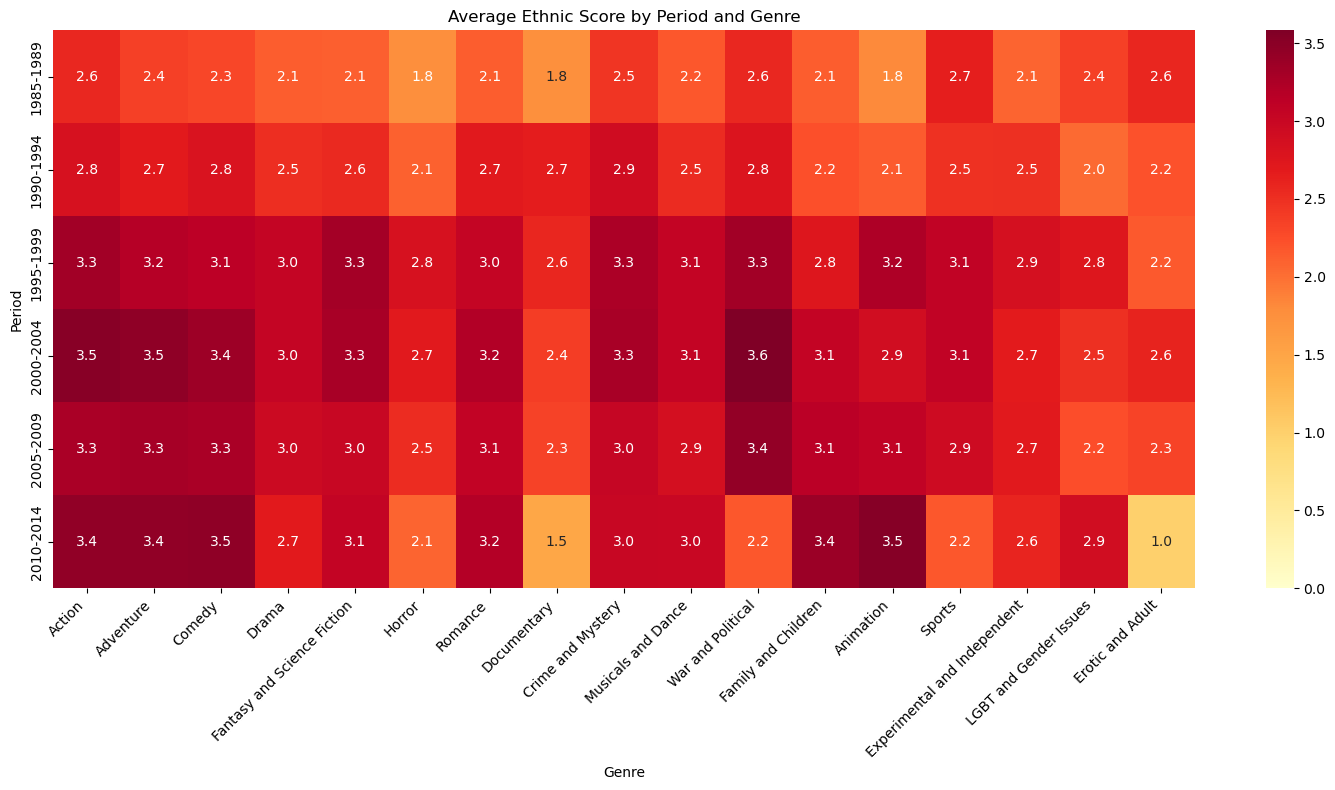

In [20]:
plot_ethnic_score_heatmap(df)

**Observations:** Ethnic diversity in movies has increased steadily across most genres from the 1980s to the 2010s. Action, Adventure, and Comedy maintain higher average scores, reflecting consistent diversity. Romance and Animation show gradual growth over time, while Documentaries and Erotic films exhibit significantly lower scores. Overall, diversity trends vary across genres, with some showing consistent progress and others remaining less representative.

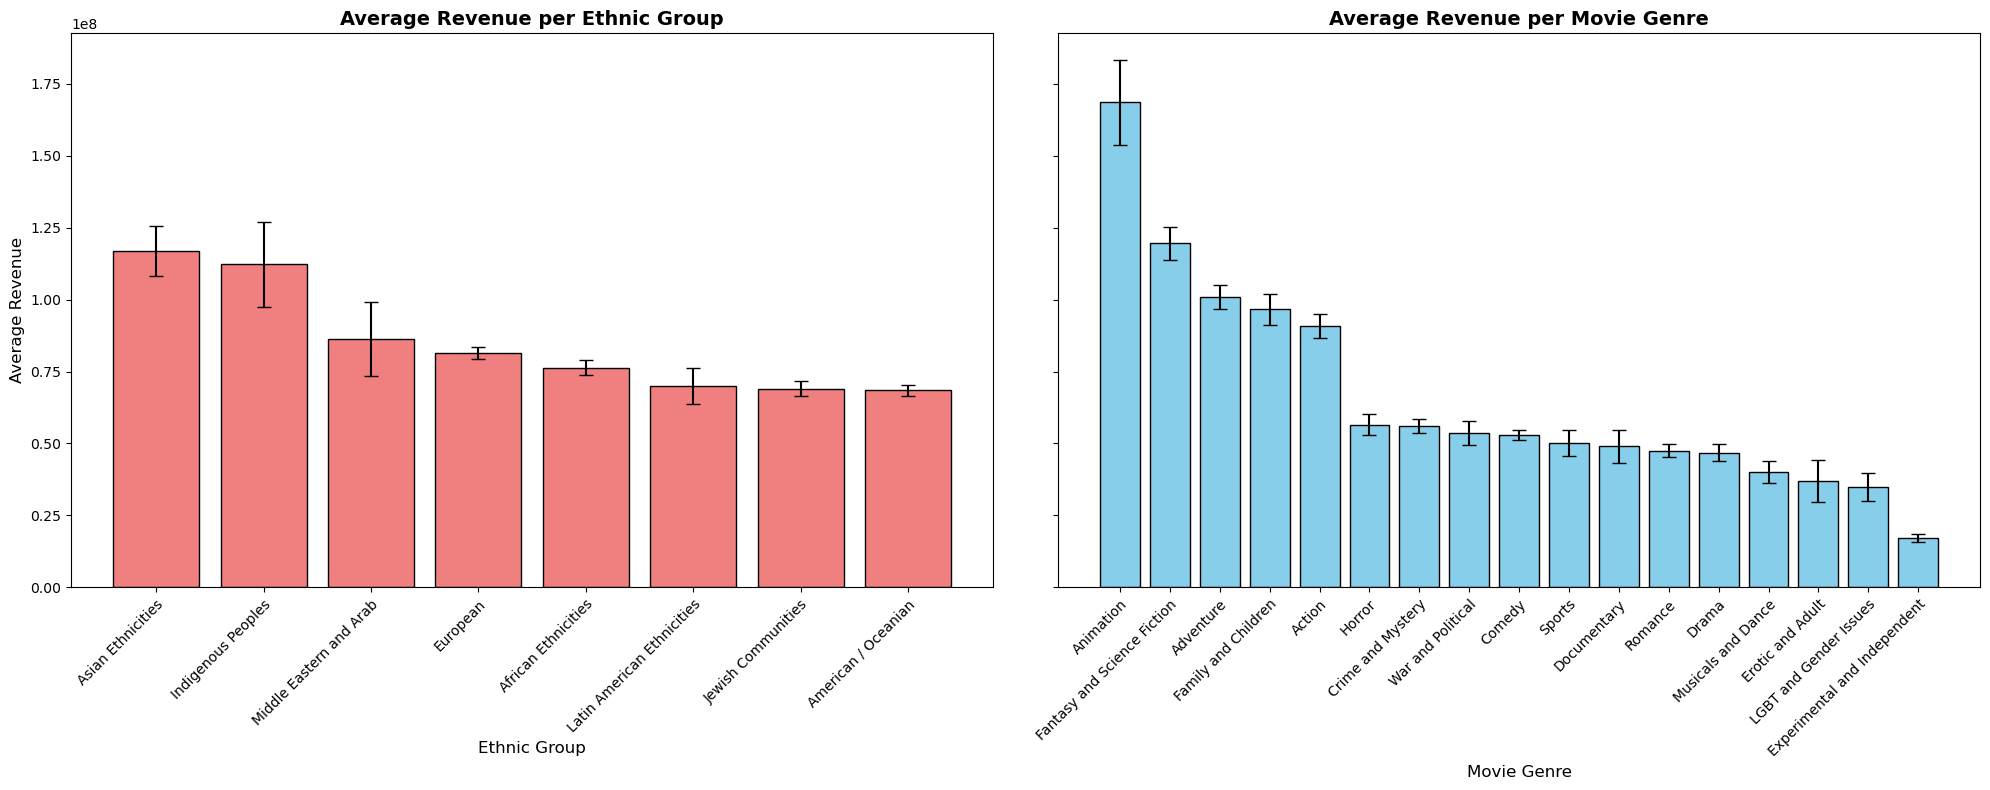

In [21]:
plot_ethnicity_and_genre_influence_on_revenue(df)

**Observations 1:** Movies featuring Asian ethnicities and Indigenous Peoples lead in average revenue, reflecting their growing appeal and the success of culturally significant stories. Other ethnic groups, such as Middle Eastern and African, follow closely, with only minor variations in earnings, indicating consistent audience interest across diverse cultures.

**Observations 2:** Animation dominates in revenue, driven by its universal appeal and blockbuster franchises. Fantasy, Sci-Fi, Adventure, and Family genres also perform well, supported by their large budgets and global fanbases. In contrast, Drama, LGBT and Gender Issues, and Experimental films lag behind, highlighting the financial challenges faced by niche or critically acclaimed genres. Experimental films bring in the lowest revenue, underscoring the uphill battle for smaller productions.


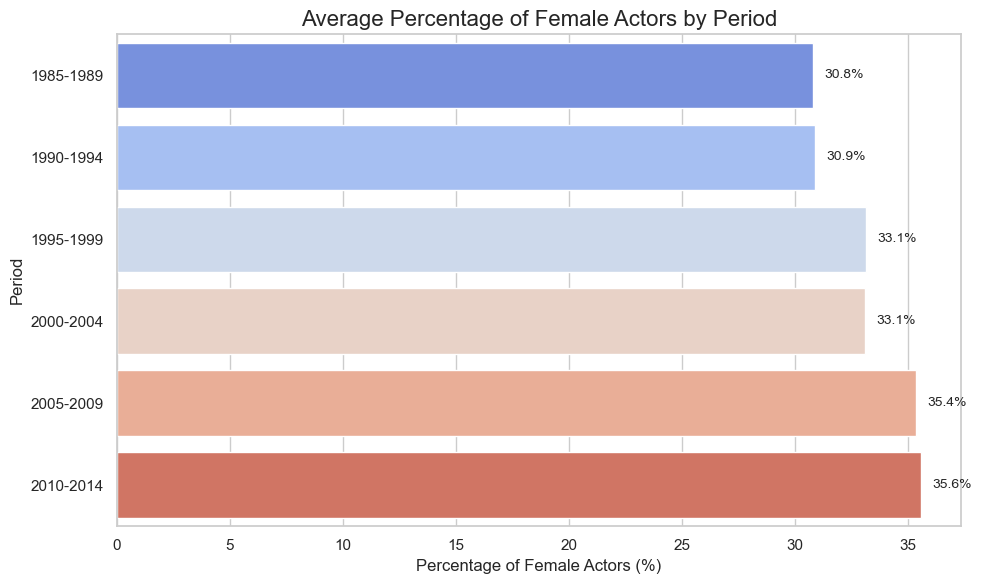

In [22]:
plot_female_ratio_distribution(df)

**Observations :** We can see that the female representation is increasing over time, revealing that the movie industry indeed tend to be more inclusive nowadays.

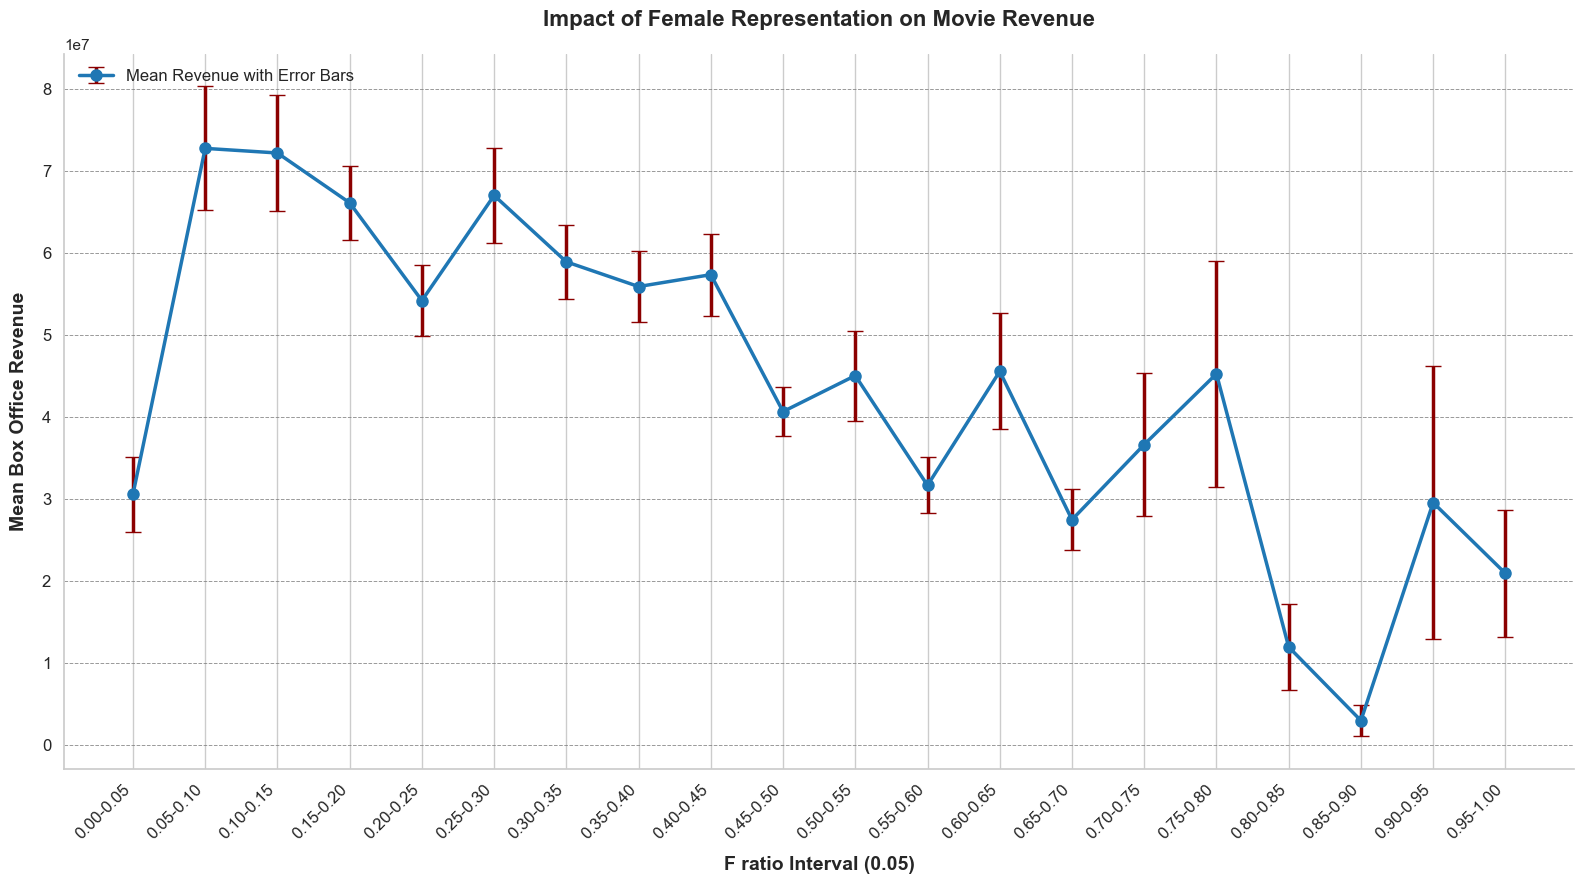

In [23]:
plot_mean_revenue_by_f_ratio(df)

**Observations:** Movies with too few or too many female cast members tend to generate lower revenues. This pattern suggests a balance is expected, where female representation aligns with traditional gender roles. A higher proportion of women challenges male-dominated narratives, while too few fails to meet audience expectations for supporting or stereotypical roles. This trend highlights lingering biases in the depiction of women in cinema and their roles in storytelling.

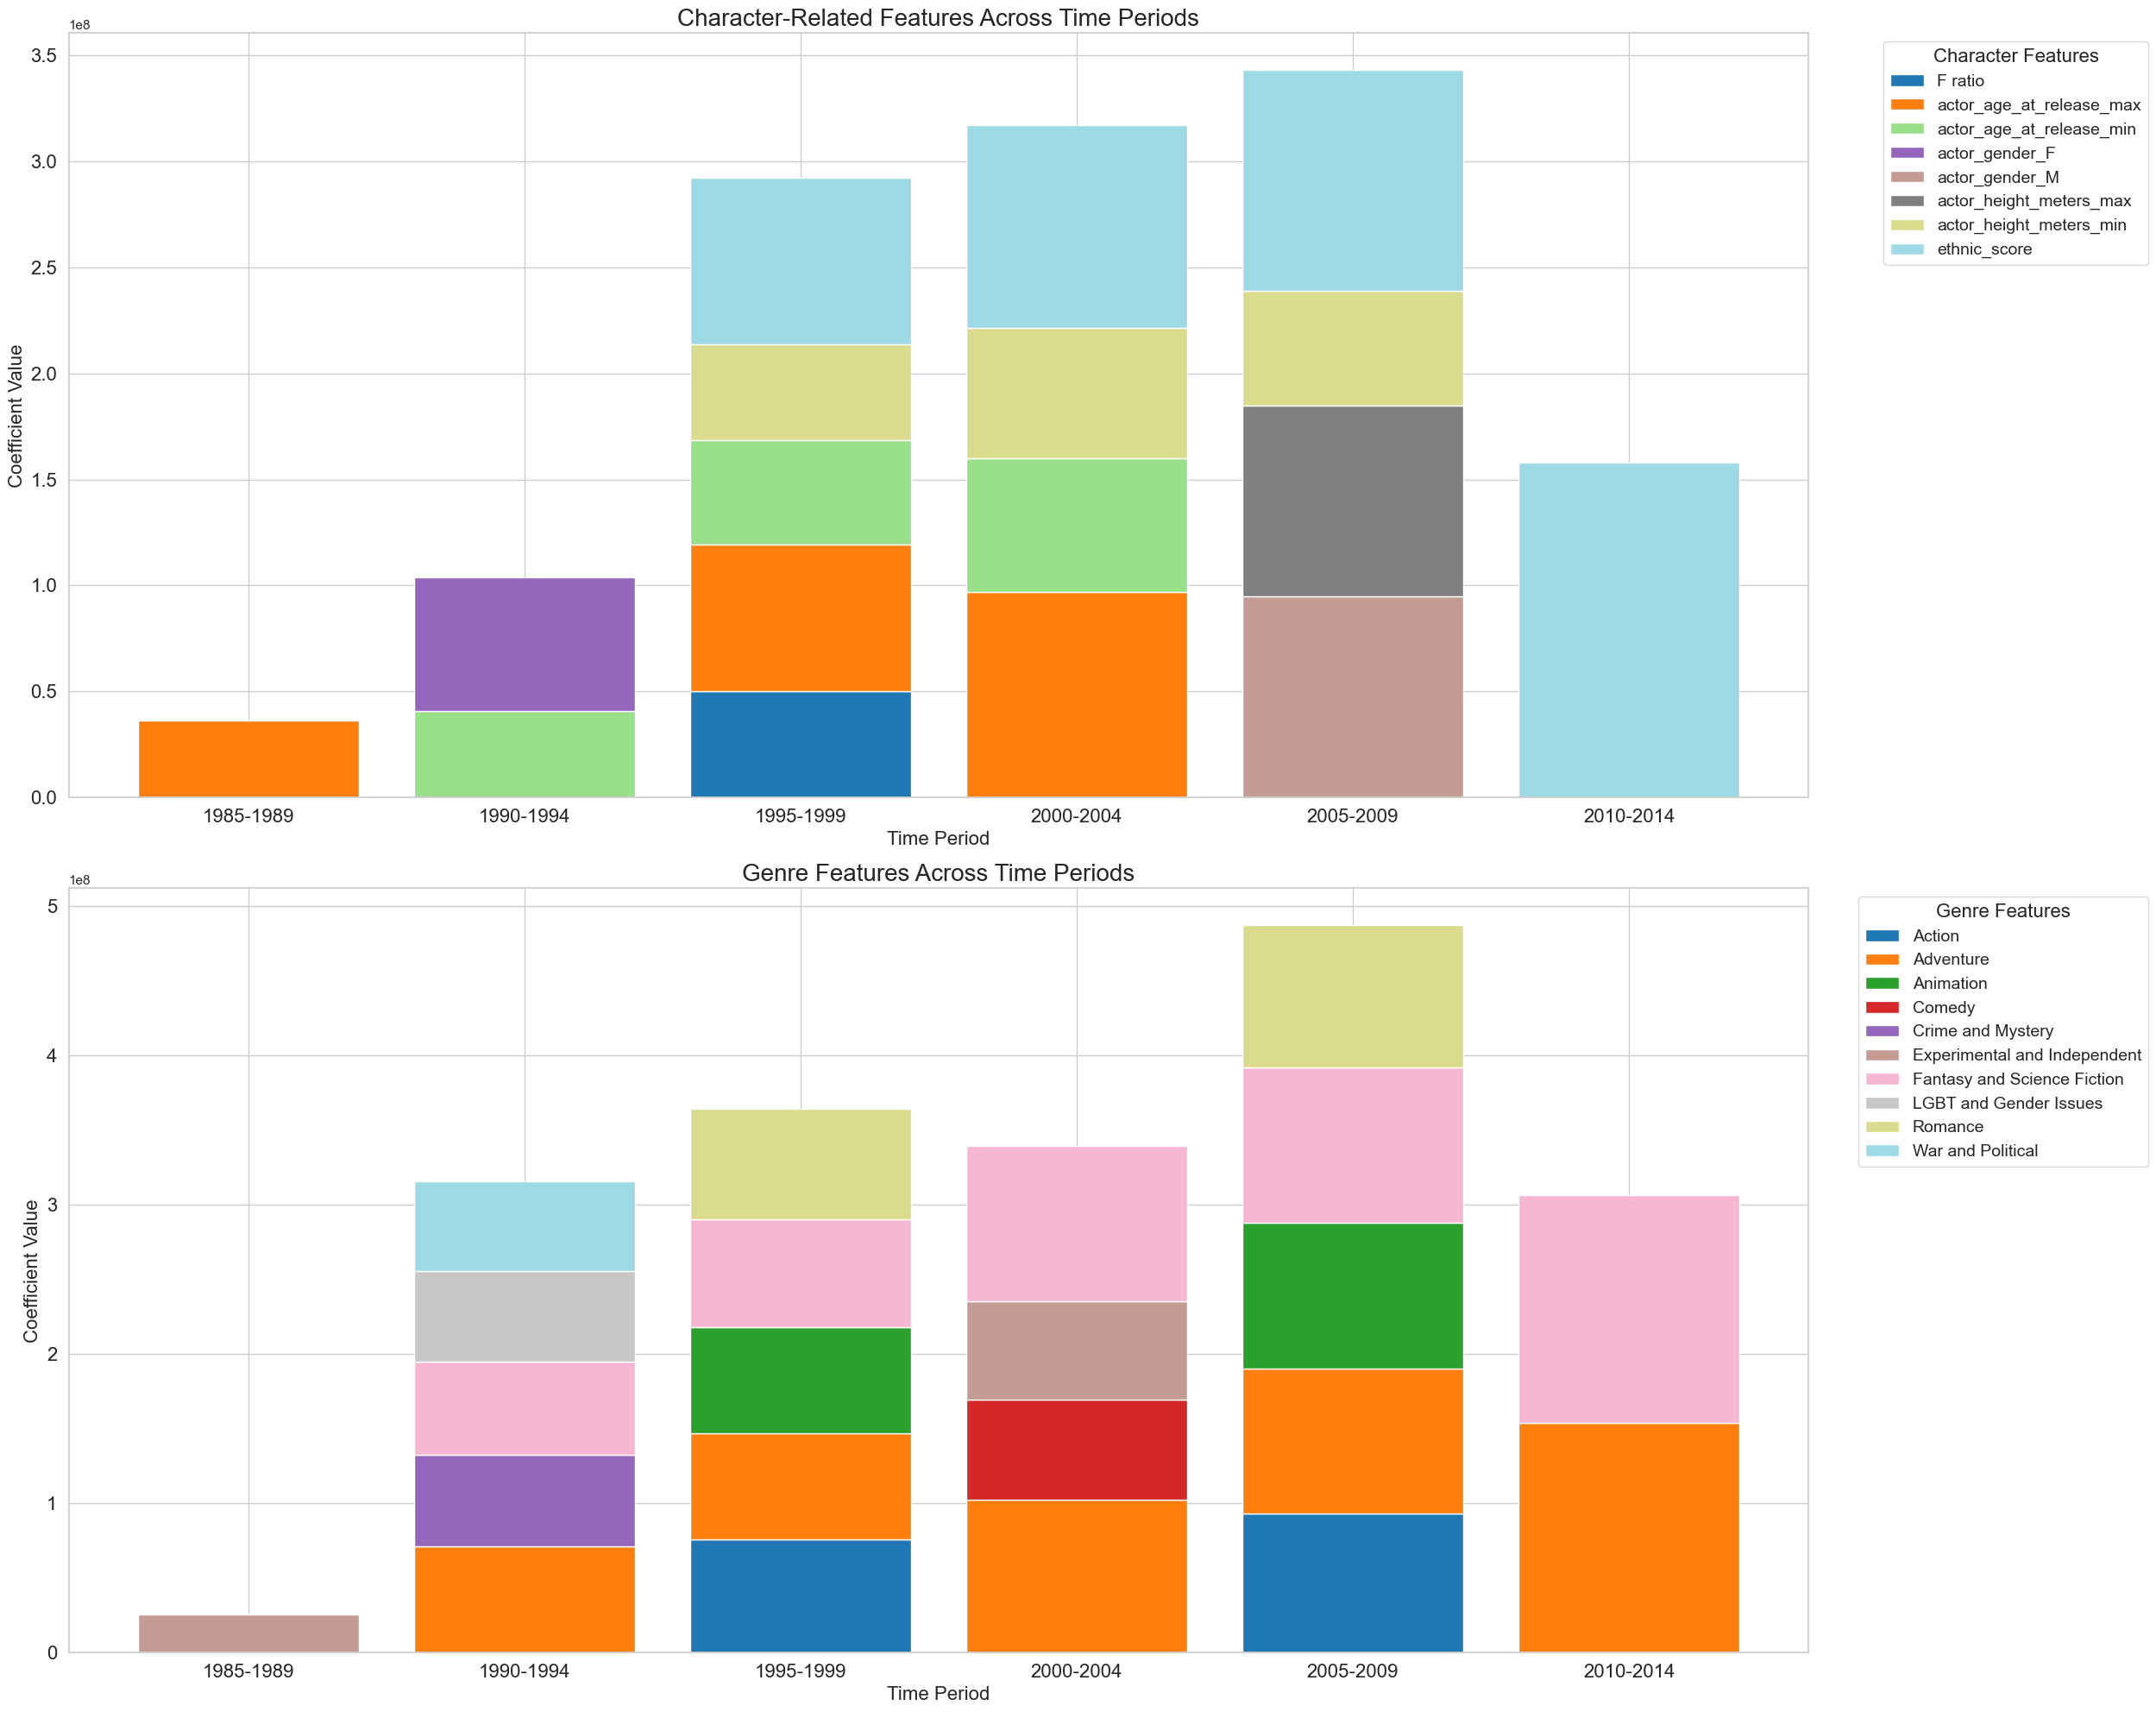

In [24]:
features = ridge_regression_characters_general(df)
plot_important_features_only_considering_ethnic_score(features)

**Observations 1:** From 1995 onwards, higher ethnic scores are associated with higher box office revenues, aligning with studies highlighting the broad appeal of diverse representation. Between 1990 and 1999, female presence in casts had a significant positive impact on revenues, coinciding with the rise of successful Romance films during the same period. Younger actors also gained increased audience interest in the early 1990s.

**Observations 2:** Genre trends reveal the growing popularity of Sci-Fi, Adventure, and Romance in recent decades, alongside the rise of themes like LGBTQ+ representation, particularly toward the end of the 20th century. Notably, political and war-themed movies saw success in the 1990s, reflecting societal shifts following the Cold War. These patterns underscore the evolving preferences of movie audiences over time.

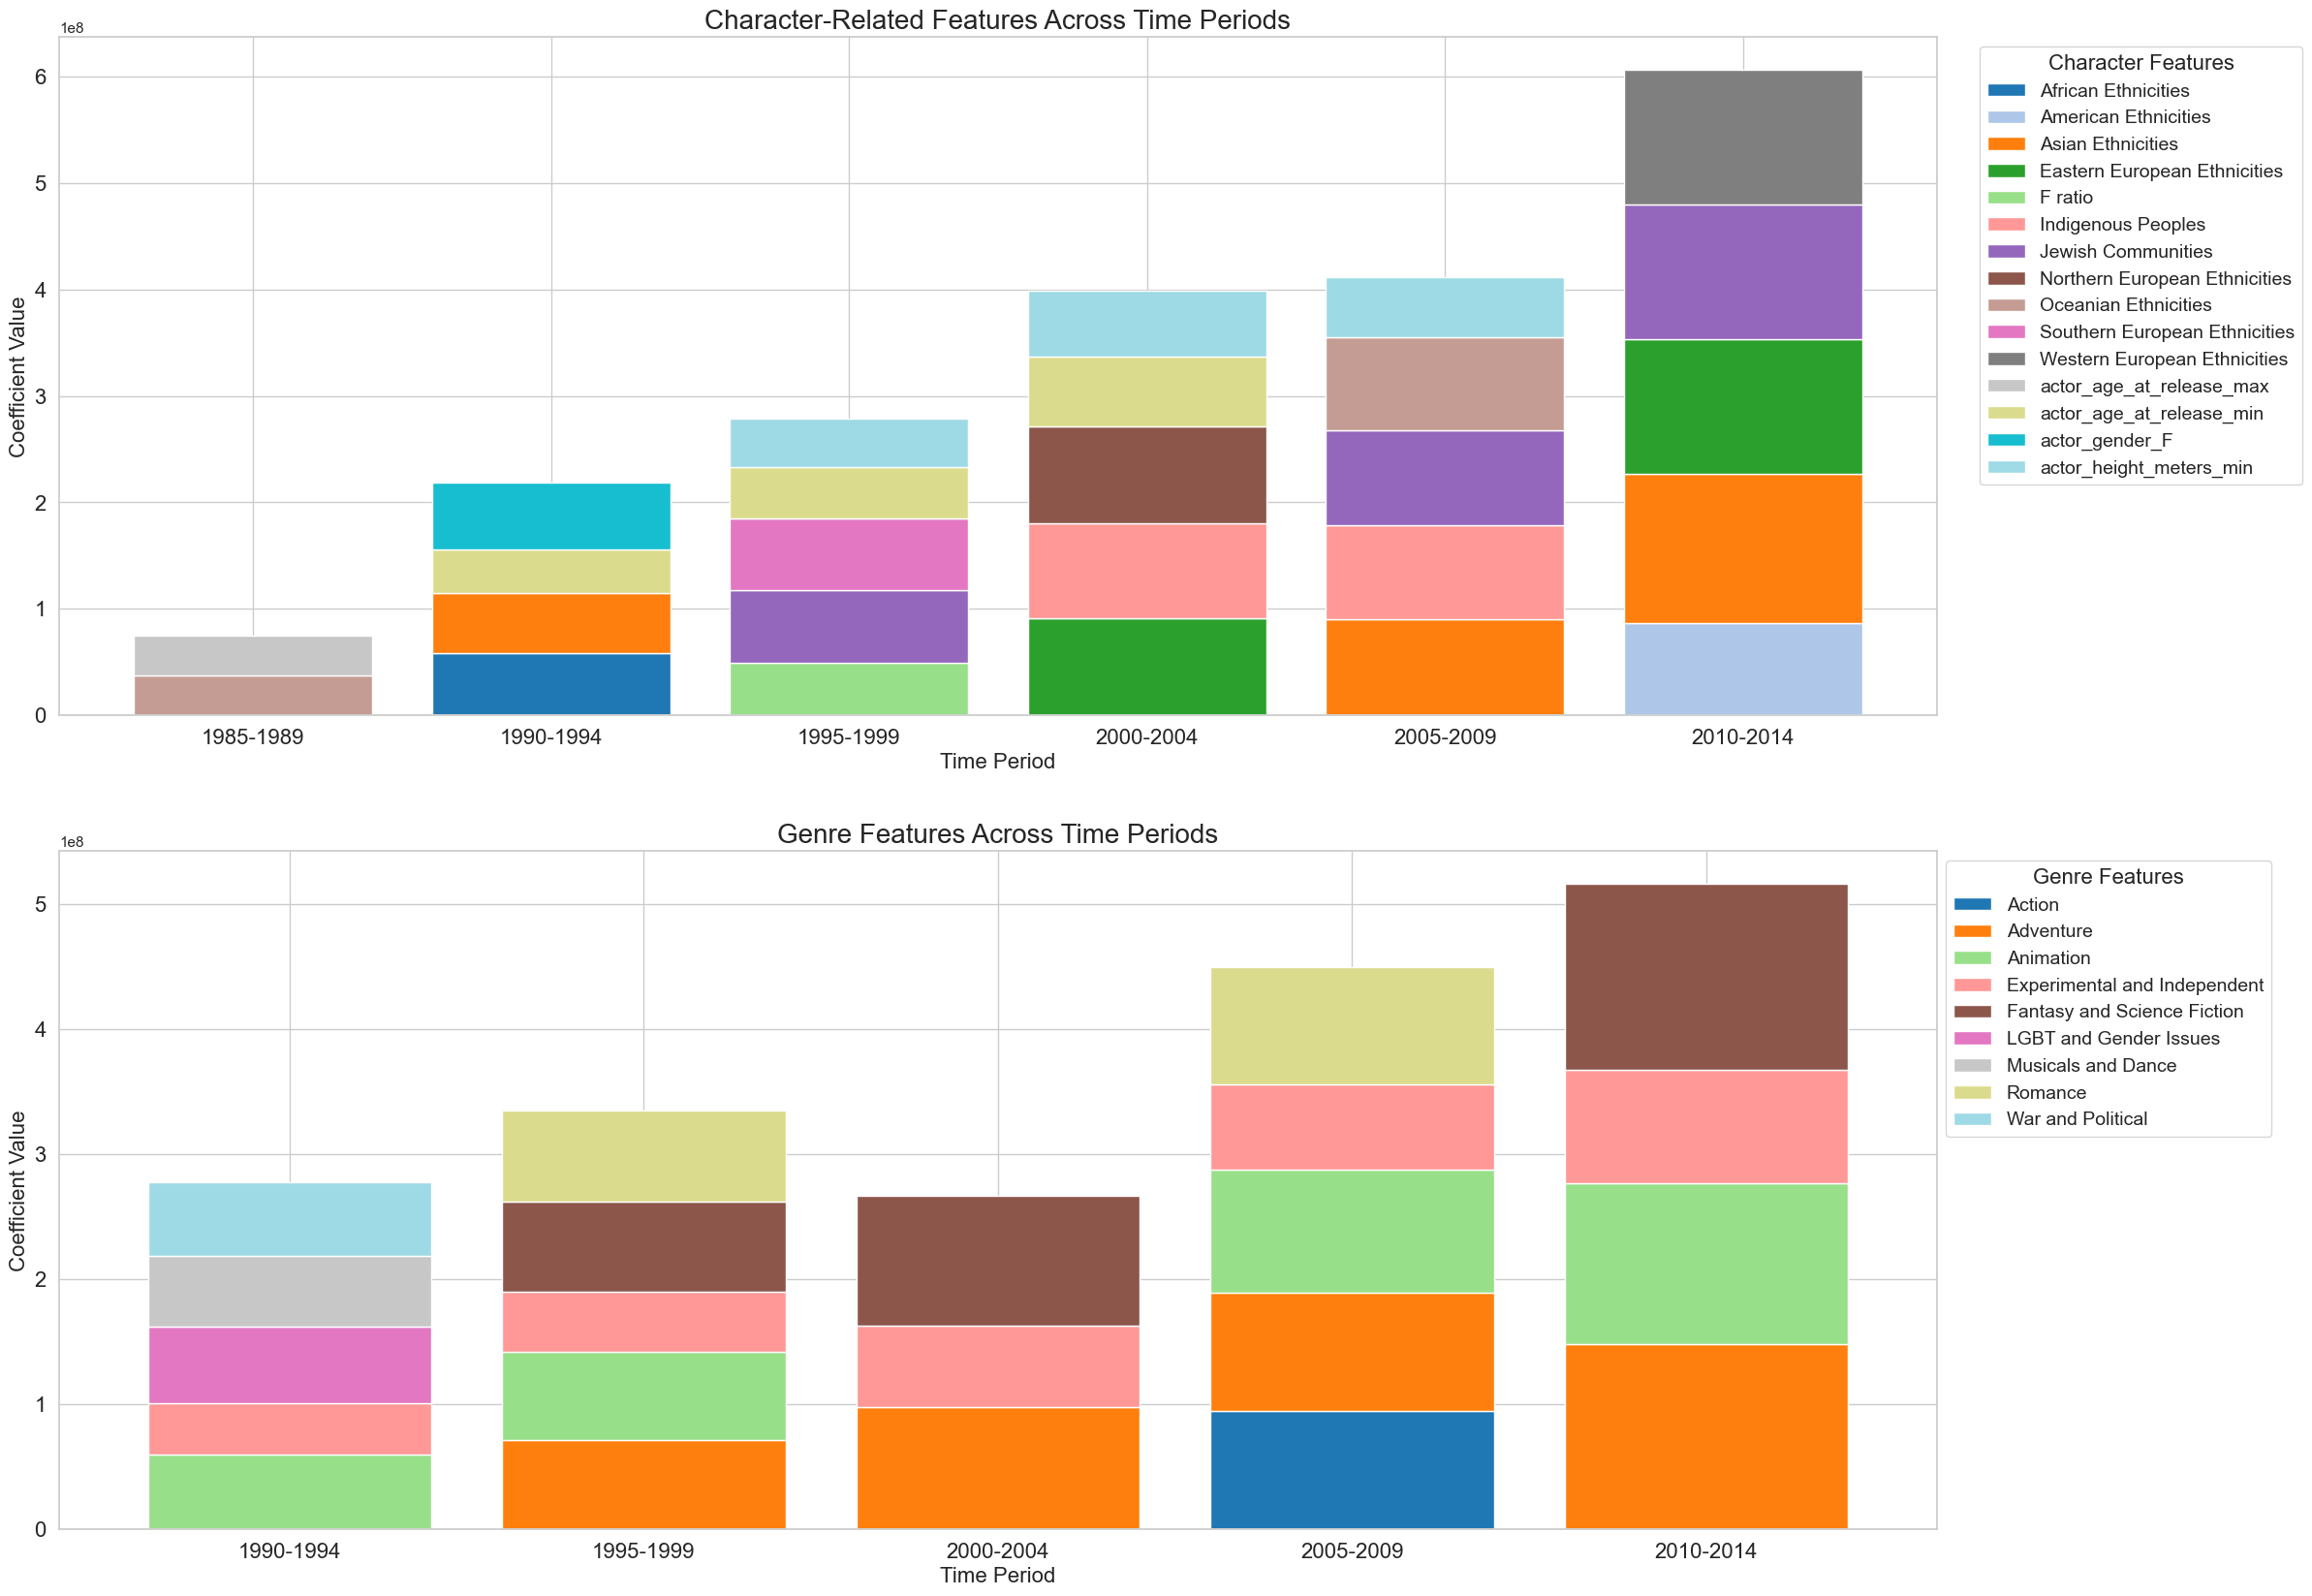

In [25]:
features = ridge_regression_characters(df)
plot_important_features(features)

**Observations 1:** Since 2010, successful movies increasingly feature Jewish actors, reflecting both talent-driven success and greater public openness to Jewish representation. Similar trends for African ethnicities in the 1990s and Indigenous representation in the early 2000s highlight societal shifts towards diversity. However, white ethnicities (European and North American) consistently dominate, maintaining the historical spotlight.

**Observations 2:** Sci-Fi, Adventure, and Romance maintain strong popularity across decades, while themes like LGBTQ+ issues gain prominence in the 2000s, reflecting shifting societal values. Political and war genres saw notable success in the 1990s, aligning with global events such as the post-Cold War era. Experimental and Independent films remain niche, showing limited growth in popularity.

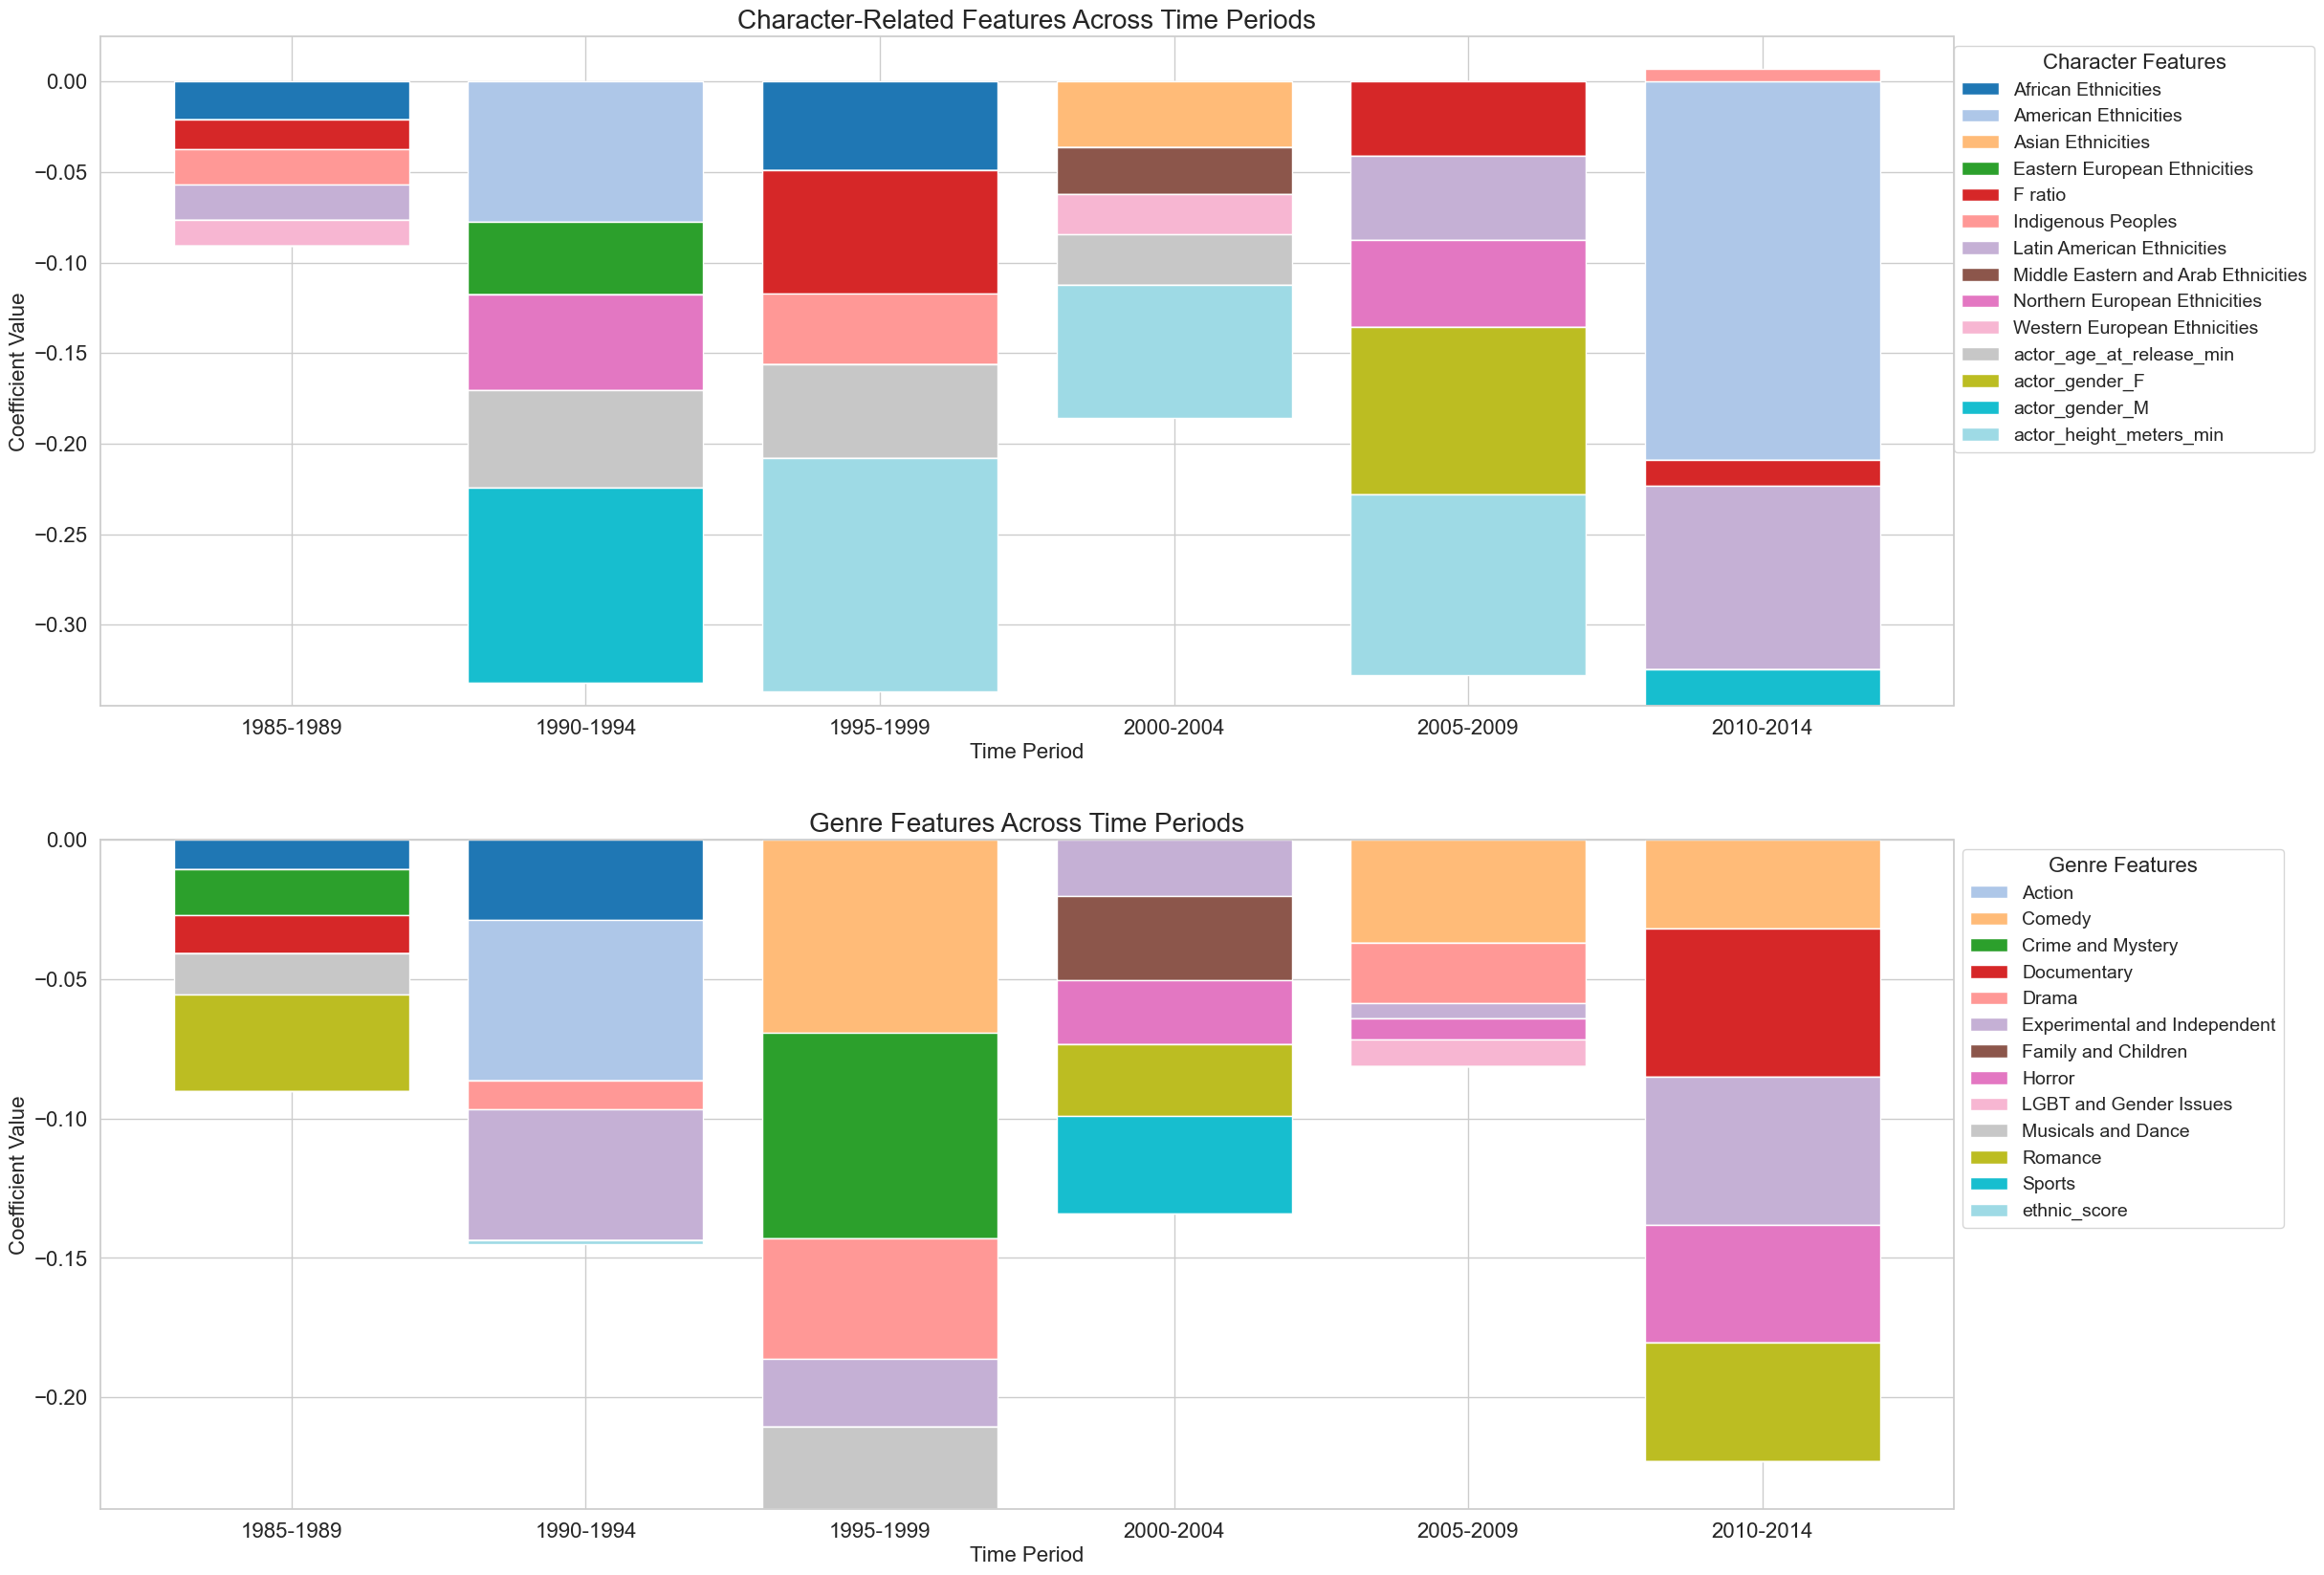

In [29]:
features = logistic_regression(df)
plot_important_features(features)

**Observations 1:** Using logistic regression, we confirm the positive impact of ethnic representation on movie success. Features like African, Indigenous, and Jewish ethnicities show increased significance over time, aligning with societal appreciation for diversity and its role in boosting box office revenues. Gender and age also contribute, but the prominence of ethnic diversity strongly supports our earlier findings.

**Observations 2:** Logistic regression results highlight the importance of the ethnic score across genres, reaffirming that movies with higher ethnic representation resonate with broader audiences. Genres such as Drama and Romance reflect societal changes, while LGBTQ+ and experimental themes gain traction in later years. These findings underscore the power of diverse storytelling in driving movie success.
